## Test for LindeMod dataset

In [2]:
import numpy as np
import open3d as o3d
import yaml

CONNECT_CAM = False
ENABLE_DETECT = False
ENABLE_O3D = True

CONNECT_INDY = False
CONNECT_MOBILE = False

CONNECT_TASK_PLANNER = False
VISUALIZE = False
VERBOSE = False
PLANNING_MULTIPROC = True
N_AGENTS = 10
NODE_TRIAL_MAX = N_AGENTS * 2
MAX_SOL_NUM = 5
BASE_COST_CUT = 110

TIMEOUT_MOTION = 0.5
TIMEOUT_FULL = 5

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.15, 0.32]
TOOL_THICKNESS = 0.05
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

COL_COLOR = (1,1,1,0.2)

IP_CUR = "192.168.0.10"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.10
Mobile ROB IP: 192.168.0.102


In [3]:
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/perception'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.detector.multiICP.multiICP import *
from pkg.detector.camera.realsense import RealSense
from pkg.detector.multiICP.config import *

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *
from demo_utils.area_select import DATASET_DIR, SweepDirections
from demo_utils.demo_config import *
# from demo_utils.detection_util import *
from demo_utils.detection_util_bak import *

from pkg.utils.shared_function import *
clear_channels_on("kiromobilemap")

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7kiro, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})

ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[CONNECT_MOBILE, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)
gscene.set_workspace_boundary(
    -4, 12, -7, 5, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
CAM_LINK = TIP_LINK.replace("tcp", "link6")
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=CAM_LINK, center=(-0.0785, 0, 0.073))

add_brush(gscene, face_name=TOOL_NAME, tool_link=TIP_LINK,
          thickness=TOOL_THICKNESS, tool_dim=TOOL_DIM,
          col_color=COL_COLOR)

HOME_POSE = crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

mplan.reset_PRQdict(enable_PRQ=0.5, radii=5e-2)
for tip_dir, SWEEP_AXIS in [
    (SweepDirections.front, "X"), (SweepDirections.up, "Z"), (SweepDirections.down, "Z")]:
    filename = SweepDirections.get_file_name(ROBOT_TYPE, tip_dir.name+SWEEP_AXIS)+"-PRQ.pkl"
    PRQ_PATH = os.path.join(DATASET_DIR, filename)
    try:
        Pos_Rotvec_Qlist_dict = load_pickle(PRQ_PATH)
        mplan.register_PRQ(ROBOT_NAME, Pos_Rotvec_Qlist_dict, decimal=2)
        print("Loaded: {}".format(filename))
    except:
        print("File not exist: {}".format(filename))
        continue

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene, node_trial_max=NODE_TRIAL_MAX)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer

brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(0,0, -gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
    rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

gscene.add_highlight_axis("hl", "base_coord", T=np.identity(4), dims=(0.5,0.1,0.1))

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]
mobile_box = gscene.NAME_DICT['kmb0_platform_Box_2']

if CONNECT_MOBILE:
    assert np.sum(np.abs(get_xyzw_cur()))>1e-4, "UDP Server not connected"
    
if CONNECT_CAM:
    realsense = RealSense()

# from demo_utils.data_reconstructed_camera import DataRecontructedCamera
# dcam = DataRecontructedCamera(crob, viewpoint)

connection command:
kmb0: False
indy1: False
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Loaded: indy7kiro-frontX-PRQ.pkl
Loaded: indy7kiro-upZ-PRQ.pkl
Loaded: indy7kiro-downZ-PRQ.pkl


In [3]:
Q_CUR = crob.get_real_robot_pose()

VIEW_POSE = crob.home_pose[6:]
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
crob.joint_move_make_sure(VIEW_POSE_EXT)

In [37]:
cameraMatrix = np.array([[572.4114, 0.,         325.2611],
                         [0.,        573.57043,  242.04899],
                         [0.,        0.,         1.]])
distCoeffs = np.array([ 0., 0., 0.,  0.,  0.])

intrins=[640, 480, 572.4114, 573.57043, 325.2611, 242.04899]
depth_scale=1/1000.0

## Load dataset & Compute ICP

In [52]:
import random
T_co = []
rmse_ICP_list = []
rmse_frontICP_list = []
RRE_ICP_list = []
RTE_ICP_list = []
RRE_frontICP_list = []
RTE_frontICP_list = []
i=10
img_list = os.listdir(os.path.join(os.getcwd(), "linemod/{0:02}/rgb/".format(i)))
with open('linemod/{0:02}/gt.yml'.format(i), "r") as f:
    gt = yaml.load(f)
for j in range(len(img_list)):
    color_path = os.path.join(os.getcwd(), 'linemod/{0:02}/rgb/{1:04}.png'.format(i,j))
    depth_path = os.path.join(os.getcwd(), 'linemod/{0:02}/depth/{1:04}.png'.format(i,j))
    mask_path = os.path.join(os.getcwd(), 'linemod/{0:02}/mask/{1:04}.png'.format(i,j))

    color = cv2.imread(color_path, flags=cv2.IMREAD_UNCHANGED)
    depth = cv2.imread(depth_path, flags=cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path, flags=cv2.IMREAD_UNCHANGED)
    mask_u8 = np.zeros_like(mask).astype(np.uint8)
    mask_u8[np.where(mask)] = 255

    color_masked = cv2.bitwise_and(color, color, mask=mask_u8[:,:,2]).astype(np.uint8)
    depth_masked = cv2.bitwise_and(depth, depth, mask=mask_u8[:,:,2]).astype(np.uint16)
#         plt.imshow(color_masked[:,:,[2,1,0]])
    cdp_masked = ColorDepthMap(color_masked, depth_masked, intrins, depth_scale)

    if cdp_masked.color is None:
        pass
    else:
#             model_mesh = o3d.io.read_triangle_mesh(os.path.join(
#                             os.getcwd(),'linemod/model/obj_{0:02}.ply'.format(i+1)))
        icp_obj = MultiICP(model=os.path.join(
                        os.getcwd(),'linemod/model/obj_{0:02}.ply'.format(i)),
                        Toff=SE3(np.identity(3),(0,0,0)), scale=1e-3)
        icp_obj.add_image(cdp_masked, Tc=None)

    #     Tguess = SE3(Rot_axis(1, 2*np.pi/3), (-0.15,0,0.7))
#             Tguess = icp_obj.get_initial_by_center(Rot_axis(1, 2*np.pi/3), offset=(-0.0,0.2,0.1))
        Tguess = icp_obj.get_initial_by_center(np.identity(3), offset=(0.0,0.0,0.0))
        r = gt[j][0]['cam_R_m2c']
        R_gt = np.array([[r[0], r[1], r[2]],
                      [r[3], r[4], r[5]],
                      [r[6], r[7], r[8]]])
        T_gt = np.array(gt[j][0]['cam_t_m2c']) * 1e-3
        
        # random offset
        dim = np.linalg.norm(icp_obj.model.get_max_bound() - icp_obj.model.get_min_bound())
        t_delta = (random.uniform(-dim/3., dim/3.),
                   random.uniform(-dim/3., dim/3.),
                   random.uniform(-dim/3., dim/3.))
        T_est = T_gt + t_delta
        Tguess = SE3(R_gt, T_est)
        T_ICP, rmse_ICP = icp_obj.compute_ICP(To=Tguess, thres=dim/2., visualize=False)
        T_frontICP, rmse_frontICP = icp_obj.compute_front_ICP(To=T_ICP, thres=dim/2., visualize=False)
        
        RRE_ICP = np.arccos((np.trace(np.matmul(T_ICP[:3,:3].T, R_gt))-1)/2)
        RTE_ICP = np.linalg.norm(T_ICP[:3,3] - T_gt)
        
        RRE_frontICP = np.arccos((np.trace(np.matmul(T_frontICP[:3,:3].T, R_gt))-1)/2)
        RTE_frontICP = np.linalg.norm(T_frontICP[:3,3] - T_gt)
        print("+++++++++++++++++++++++++++++++++++")
        print("RRE_ICP(degree): {}".format(RRE_ICP))
        print("RTE_ICP(m): {}".format(RTE_ICP))
        print("RRE_frontICP(degree): {}".format(RRE_frontICP))
        print("RTE_frontICP(m): {}".format(RTE_frontICP))
        print("+++++++++++++++++++++++++++++++++++")
        T_co.append(T_frontICP)
        rmse_ICP_list.append(rmse_ICP)
        rmse_frontICP_list.append(rmse_frontICP)
        RRE_ICP_list.append(RRE_ICP)
        RTE_ICP_list.append(RTE_ICP)
        
        RRE_frontICP_list.append(RRE_frontICP)
        RTE_frontICP_list.append(RTE_frontICP)

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.106745e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[-0.19709553  0.97895016 -0.05300282 -0.03220965]
 [ 0.96119459  0.18231143 -0.20704378 -0.0878748 ]
 [-0.19302284 -0.0917535  -0.97689498  0.93729072]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=8.831591e-03, and correspondence_set size of 243
Access transformation to get result.
Transformation is:
[[-0.17101488  0.98521624 -0.0101117  -0.03215151]
 [ 0.9689519   0.16631456 -0.1829516  -0.08467044]
 [-0.17856545 -0.04108527 -0.98307004  0.95828912]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.118772966657
RTE_ICP(m): 0.0212878046379
RRE_frontICP(degree): 0.0897662778436
RTE_frontICP(m): 0.00403008429043
++++++++++++++++++

Access transformation to get result.
Transformation is:
[[-6.00029027e-01  7.34606770e-01 -3.16729794e-01  9.69128494e-02]
 [ 7.91573452e-01  4.87967497e-01 -3.67830353e-01  8.29726196e-04]
 [-1.15657331e-01 -4.71423436e-01 -8.74290030e-01  9.00419356e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.389141e-02, and correspondence_set size of 271
Access transformation to get result.
Transformation is:
[[-0.65098856  0.72213195 -0.23396361  0.10374312]
 [ 0.67807843  0.4146626  -0.60684798 -0.00113139]
 [-0.34120891 -0.55369651 -0.75960288  0.91332995]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.434191639043
RTE_ICP(m): 0.0253697251645
RRE_frontICP(degree): 0.221500801432
RTE_frontICP(m): 0.0109866637086
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fit

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.080442e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[-0.4912077   0.86497855 -0.10259927  0.06533829]
 [ 0.81193586  0.41203864 -0.41350199 -0.06979878]
 [-0.31539611 -0.28641923 -0.90470349  0.79537174]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.435389e-02, and correspondence_set size of 276
Access transformation to get result.
Transformation is:
[[-0.50039563  0.84992271 -0.16503084  0.06480433]
 [ 0.76064717  0.34051885 -0.55268633 -0.0657656 ]
 [-0.41354522 -0.40209206 -0.81688527  0.81329007]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.303175729974
RTE_ICP(m): 0.0275959359285
RRE_frontICP(degree): 0.213967462653
RTE_frontICP(m): 0.0115581409619
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.391609e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[ 0.02061772  0.6379091  -0.76983575  0.06633957]
 [ 0.8693532  -0.39171502 -0.30130392 -0.04120034]
 [-0.49376126 -0.66304731 -0.56264453  1.00678624]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.804908e-02, and correspondence_set size of 271
Access transformation to get result.
Transformation is:
[[-0.3951636   0.83613979 -0.38041556  0.08545928]
 [ 0.85229865  0.17923594 -0.49138746 -0.04140786]
 [-0.34268498 -0.51840634 -0.78346816  1.00659256]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.883145650233
RTE_ICP(m): 0.025104481602
RRE_frontICP(degree): 0.30871662103
RTE_frontICP(m): 0.0147761268069
++++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.114483e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[ 0.01567893  0.99980678  0.01183084 -0.05386619]
 [ 0.7819404  -0.00488638 -0.62333456  0.08928541]
 [-0.6231568   0.01902422 -0.78186619  1.02861698]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.624371e-02, and correspondence_set size of 277
Access transformation to get result.
Transformation is:
[[ 0.02445391  0.99959001 -0.01487338 -0.06096967]
 [ 0.79314434 -0.02845565 -0.6083691   0.09502803]
 [-0.6085434   0.00308027 -0.79351528  1.04251545]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.0561889064815
RTE_ICP(m): 0.0241762610077
RRE_frontICP(degree): 0.0326632664246
RTE_frontICP(m): 0.00934928673383
+++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.051247e-02, and correspondence_set size of 159
Access transformation to get result.
Transformation is:
[[ 4.39488485e-03  9.61353790e-01 -2.75280530e-01  3.07625889e-02]
 [ 9.55626390e-01 -8.51225399e-02 -2.82015382e-01  3.46272015e-04]
 [-2.94548288e-01 -2.61824982e-01 -9.19069641e-01  7.90866273e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.422207e-02, and correspondence_set size of 292
Access transformation to get result.
Transformation is:
[[ 8.13689877e-02  9.46162678e-01 -3.13297250e-01  3.23547241e-02]
 [ 9.20618710e-01 -1.91791661e-01 -3.40114018e-01  7.97694156e-04]
 [-3.81890147e-01 -2.60751651e-01 -8.86661344e-01  8.10752841e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.134

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.106235e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[-0.35343702  0.92100871 -0.16378206  0.14975275]
 [ 0.75812792  0.17944528 -0.62693023 -0.00523132]
 [-0.54801809 -0.34574802 -0.76166565  0.88458404]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.481993e-02, and correspondence_set size of 275
Access transformation to get result.
Transformation is:
[[-0.40723419  0.8684988  -0.28261199  0.15064744]
 [ 0.72619206  0.12024411 -0.67689481  0.00518488]
 [-0.55389972 -0.48088515 -0.679665    0.90193492]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.236435215928
RTE_ICP(m): 0.0319712139373
RRE_frontICP(degree): 0.240156412803
RTE_frontICP(m): 0.0133456011946
++++++++++++++++++++

Transformation is:
[[ 0.27428855  0.96034513 -0.05002664  0.04841358]
 [ 0.83754648 -0.26413012 -0.47827838 -0.02974108]
 [-0.47252593  0.08928664 -0.87678186  0.95495272]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.458136254916
RTE_ICP(m): 0.0276108420001
RRE_frontICP(degree): 0.27173125817
RTE_frontICP(m): 0.0122554169951
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.049451e-02, and correspondence_set size of 149
Access transformation to get result.
Transformation is:
[[ 0.06585863  0.98665508 -0.14890904  0.02544123]
 [ 0.90908428 -0.12085365 -0.39869716  0.0115666 ]
 [-0.41137249 -0.10911397 -0.90491224  0.89807724]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.517967e-02, and correspondence_set size of 280
Access transformation 

registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.862703e-02, and correspondence_set size of 299
Access transformation to get result.
Transformation is:
[[ 6.26552962e-01  7.28205941e-01 -2.77752368e-01  1.70809998e-01]
 [ 4.85342854e-01 -6.43398127e-01 -5.92014908e-01 -2.76330296e-04]
 [-6.09814364e-01  2.36123501e-01 -7.56552364e-01  1.04370611e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.578762077139
RTE_ICP(m): 0.0385213253917
RRE_frontICP(degree): 0.297549947133
RTE_frontICP(m): 0.0242726490692
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.016583e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[ 0.68287464  0.66938308 -0.29258911  0.18089072]
 [ 0.59927526 -0.74233976 -0.29966741  0.02464876]
 [-0.41779258  0.02929358 -0.90807025  0.9767199

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=7.929092e-03, and correspondence_set size of 259
Access transformation to get result.
Transformation is:
[[ 0.75548531  0.61914842 -0.21423418  0.07354578]
 [ 0.57743736 -0.78373693 -0.22873927  0.01172894]
 [-0.30952674  0.04910312 -0.94962221  0.91094534]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.221268677294
RTE_ICP(m): 0.0261674327993
RRE_frontICP(degree): 0.135112204556
RTE_frontICP(m): 0.00480541800588
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.009980e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[ 0.61405385  0.74684537 -0.25526275  0.02283458]
 [ 0.74740358 -0.65416361 -0.1160112  -0.02294855]
 [-0.25362601 -0.11954704 -0.95988682  0.7825033 ]
 [ 0.          0.          0.      

Access transformation to get result.
Transformation is:
[[ 0.8359195   0.28532461 -0.46885828  0.01907031]
 [ 0.28042593 -0.95636394 -0.08202878 -0.05804465]
 [-0.47180454 -0.06291061 -0.87945584  0.75075421]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.707357313113
RTE_ICP(m): 0.054478188085
RRE_frontICP(degree): 0.256352616952
RTE_frontICP(m): 0.0153259078147
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.118553e-02, and correspondence_set size of 161
Access transformation to get result.
Transformation is:
[[ 0.42903968  0.88962106 -0.15652439 -0.03518411]
 [ 0.86450827 -0.45463588 -0.2143153  -0.09491338]
 [-0.26182054 -0.04336728 -0.96414151  0.68854601]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.195382e-02, and correspondence_s

Transformation is:
[[ 0.56195288  0.81042206 -0.16560457 -0.01121523]
 [ 0.74047561 -0.58209877 -0.33594214 -0.01650744]
 [-0.36865334  0.06615707 -0.92720991  1.04825203]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.227768e-02, and correspondence_set size of 231
Access transformation to get result.
Transformation is:
[[ 0.58517569  0.78676003 -0.19641262 -0.00869627]
 [ 0.64582737 -0.59864687 -0.47384511 -0.01490041]
 [-0.49038442  0.15043353 -0.85842478  1.06492224]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.360138201425
RTE_ICP(m): 0.0237688939398
RRE_frontICP(degree): 0.218351069747
RTE_frontICP(m): 0.00860150352411
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.983877e-02, and correspondence_set size of 152
Access transformatio

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.089082e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[-0.1938823   0.96939242 -0.15062546  0.07022649]
 [ 0.87126201  0.09957873 -0.48061004  0.03093397]
 [-0.4509006  -0.22441655 -0.86390155  0.98664692]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.536613e-02, and correspondence_set size of 240
Access transformation to get result.
Transformation is:
[[-0.25289226  0.95030159 -0.1815828   0.07241234]
 [ 0.80315943  0.10156417 -0.58704271  0.03895347]
 [-0.53942527 -0.29429913 -0.78892869  1.00118323]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.358105888775
RTE_ICP(m): 0.0302840897122
RRE_frontICP(degree): 0.278972670454
RTE_frontICP(m): 0.0162604608701
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.100053e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[-0.22733811  0.92230803 -0.3125152   0.04121311]
 [ 0.97366162  0.20956034 -0.08982196 -0.09793461]
 [-0.01735263 -0.32470352 -0.94565641  1.00229889]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.177464e-02, and correspondence_set size of 221
Access transformation to get result.
Transformation is:
[[-0.21323659  0.90550349 -0.36687064  0.04952783]
 [ 0.97519053  0.17441588 -0.13631959 -0.09385044]
 [-0.0594497  -0.38683659 -0.92022969  1.02065241]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.211725464247
RTE_ICP(m): 0.0211412257181
RRE_frontICP(degree): 0.270747084864
RTE_frontICP(m): 0.00306079218681
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.177523e-02, and correspondence_set size of 294
Access transformation to get result.
Transformation is:
[[ 0.06662257  0.98973933 -0.12639904 -0.07856923]
 [ 0.97625662 -0.0908296  -0.19665243  0.02820409]
 [-0.20611579 -0.11029727 -0.9722919   0.81137301]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.314405659603
RTE_ICP(m): 0.0202959958629
RRE_frontICP(degree): 0.297597746601
RTE_frontICP(m): 0.00603921274834
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.044203e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[-0.15566144  0.98459513 -0.0796389  -0.05622736]
 [ 0.97273515  0.138756   -0.18583058  0.01542885]
 [-0.17191801 -0.10639399 -0.97934926  0.76209716]
 [ 0.          0.          0.      

+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.496581495276
RTE_ICP(m): 0.0220854518027
RRE_frontICP(degree): 0.127100894826
RTE_frontICP(m): 0.00900991452315
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.191041e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[-0.40445516  0.90745054  0.11379696 -0.14194712]
 [ 0.7954527   0.41044865 -0.44585503  0.02175523]
 [-0.45129882 -0.08980826 -0.88784236  1.04916728]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.360895e-02, and correspondence_set size of 251
Access transformation to get result.
Transformation is:
[[-0.70928636  0.69318459  0.12809398 -0.14600593]
 [ 0.56813991  0.66970993 -0.47823167  0.03131492]
 [-0.41728826 -0.2664279  -0.86884228  1.06489765]
 [ 0.          0.          0.      

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.073295e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[-0.62253013  0.76758117 -0.15256455 -0.04118932]
 [ 0.68785268  0.44368875 -0.57445597  0.04304449]
 [-0.37325033 -0.46255774 -0.8041915   0.99654124]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.637287e-02, and correspondence_set size of 266
Access transformation to get result.
Transformation is:
[[-0.63171179  0.73404922 -0.24922381 -0.0376741 ]
 [ 0.66264523  0.34447907 -0.66500832  0.04266965]
 [-0.40229641 -0.58524024 -0.70402485  1.01496826]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.0687036663426
RTE_ICP(m): 0.0253103953234
RRE_frontICP(degree): 0.148672716835
RTE_frontICP(m): 0.00875223400133
++++++++++++++++++

Transformation is:
[[-9.34895579e-01  3.48520628e-01 -6.71084243e-02 -5.85641403e-04]
 [ 3.53479761e-01  8.97271960e-01 -2.64487978e-01 -7.26967197e-02]
 [-3.19655407e-02 -2.70990795e-01 -9.62051382e-01  9.54341575e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.469649e-03, and correspondence_set size of 233
Access transformation to get result.
Transformation is:
[[-0.91542455  0.38506667 -0.11713899 -0.00188968]
 [ 0.40162149  0.85481232 -0.32862555 -0.0726759 ]
 [-0.02641136 -0.3478781  -0.93716807  0.97812778]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.119753442672
RTE_ICP(m): 0.0288166947193
RRE_frontICP(degree): 0.10302861087
RTE_frontICP(m): 0.00620089344066
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.1034

Access transformation to get result.
Transformation is:
[[-0.66201922  0.74176295 -0.10732339 -0.01365105]
 [ 0.56292643  0.39756706 -0.7246057  -0.08393181]
 [-0.49481757 -0.54011751 -0.68075525  1.07205299]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.448478714823
RTE_ICP(m): 0.0241081389051
RRE_frontICP(degree): 0.247409360551
RTE_frontICP(m): 0.0113963000875
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.980718e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[-0.66308597  0.7402348   0.11122361  0.0015808 ]
 [ 0.65244838  0.64437869 -0.39885805 -0.09096848]
 [-0.3669186  -0.19190923 -0.91024293  1.00337267]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.307366e-02, and correspondence_

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.871316e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[-0.45940278  0.88736083  0.03923986 -0.02984403]
 [ 0.73725271  0.40558312 -0.54033373 -0.05390291]
 [-0.49538624 -0.2193011  -0.84053546  0.710448  ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.253434e-02, and correspondence_set size of 319
Access transformation to get result.
Transformation is:
[[-0.49926739  0.86548917 -0.04074956 -0.02179838]
 [ 0.53473529  0.27078047 -0.80045983 -0.05399064]
 [-0.68175527 -0.42143366 -0.59799975  0.72716876]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.472208979504
RTE_ICP(m): 0.0255085760759
RRE_frontICP(degree): 0.142709450423
RTE_frontICP(m): 0.0115415535219
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.255878e-02, and correspondence_set size of 318
Access transformation to get result.
Transformation is:
[[-0.52488682  0.79032184 -0.31604669 -0.01398426]
 [ 0.62412374  0.10488582 -0.77425419 -0.00958693]
 [-0.57876128 -0.60364687 -0.54831157  0.79431582]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.47110380075
RTE_ICP(m): 0.0230126024886
RRE_frontICP(degree): 0.177696207285
RTE_frontICP(m): 0.0103348013072
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.829000e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[-0.48857083  0.8687196  -0.08138683 -0.00213112]
 [ 0.7507993   0.37105637 -0.54645909 -0.01163526]
 [-0.44452024 -0.32808884 -0.83352164  0.75056581]
 [ 0.          0.          0.        

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.873971e-02, and correspondence_set size of 151
Access transformation to get result.
Transformation is:
[[-0.59820137  0.80130399 -0.0082074   0.06085459]
 [ 0.44806589  0.32596977 -0.83245487  0.17361784]
 [-0.6643742  -0.50165276 -0.55403207  1.01149994]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.363094e-02, and correspondence_set size of 231
Access transformation to get result.
Transformation is:
[[-0.50314145  0.81039029 -0.3001939   0.06850329]
 [ 0.28959509 -0.16917715 -0.94207964  0.18184168]
 [-0.81423852 -0.56093362 -0.14956466  1.02609293]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.498558742291
RTE_ICP(m): 0.02469662615
RRE_frontICP(degree): 0.244952809636
RTE_frontICP(m): 0.0103199796219
++++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.050999e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[-0.30094226  0.94864318 -0.09751621  0.02888953]
 [ 0.84991465  0.22042392 -0.47860005 -0.01716543]
 [-0.43252622 -0.22691127 -0.8726005   0.80326019]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.487619e-02, and correspondence_set size of 275
Access transformation to get result.
Transformation is:
[[-0.28317009  0.9510886  -0.12346948  0.03241238]
 [ 0.73738418  0.13358564 -0.66213208 -0.02128068]
 [-0.6132531  -0.27854025 -0.73914508  0.82149044]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.48638699434
RTE_ICP(m): 0.0327713662691
RRE_frontICP(degree): 0.265773072434
RTE_frontICP(m): 0.0139121344176
+++++++++++++++++++++

Transformation is:
[[-0.33056601  0.91055251  0.24823405  0.05599536]
 [ 0.8052437   0.40929447 -0.42902327 -0.08707171]
 [-0.49224887  0.05806781 -0.86851599  0.6753658 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.595685e-02, and correspondence_set size of 325
Access transformation to get result.
Transformation is:
[[-0.32954649  0.8833573   0.33328524  0.05900835]
 [ 0.65257306  0.46822178 -0.59574922 -0.08967387]
 [-0.6823106   0.02116536 -0.73075642  0.69319193]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.516271035931
RTE_ICP(m): 0.0344026963983
RRE_frontICP(degree): 0.293102517585
RTE_frontICP(m): 0.0164502854249
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.122625e-02, and correspondence_set size of 148
Access transformation

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.052474e-02, and correspondence_set size of 150
Access transformation to get result.
Transformation is:
[[ 0.25790683  0.96502812  0.04695043 -0.07781483]
 [ 0.88514257 -0.21651795 -0.41187808 -0.12965233]
 [-0.38730811  0.14778361 -0.91002861  0.97855567]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.336758e-02, and correspondence_set size of 234
Access transformation to get result.
Transformation is:
[[ 0.25290157  0.96736823 -0.01546065 -0.07432852]
 [ 0.75923578 -0.20834254 -0.61656736 -0.13038424]
 [-0.59966883  0.14419215 -0.78715032  0.99608384]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.523665539409
RTE_ICP(m): 0.0284844834743
RRE_frontICP(degree): 0.298154954561
RTE_frontICP(m): 0.0115852501254
++++++++++++++++++++

Access transformation to get result.
Transformation is:
[[ 0.10022014  0.99045053 -0.09468176  0.08012288]
 [ 0.64617498 -0.13715359 -0.75076442 -0.0795795 ]
 [-0.75658013  0.01406097 -0.6537498   1.04354426]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.705042249421
RTE_ICP(m): 0.027229719212
RRE_frontICP(degree): 0.398277813458
RTE_frontICP(m): 0.0179397662252
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.107929e-02, and correspondence_set size of 149
Access transformation to get result.
Transformation is:
[[-0.12580195  0.980867   -0.14857285  0.09309435]
 [ 0.73395472 -0.00873677 -0.67914204 -0.09636441]
 [-0.66744673 -0.19448259 -0.71881305  0.98351566]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.724739e-02, and correspondence_s

Access transformation to get result.
Transformation is:
[[-3.59036150e-01  9.33242108e-01  1.23086136e-02  4.49977200e-04]
 [ 5.01964057e-01  2.04199492e-01 -8.40436450e-01  1.24635892e-02]
 [-7.86844829e-01 -2.95568652e-01 -5.41769673e-01  9.34729562e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.523312083331
RTE_ICP(m): 0.0308826635447
RRE_frontICP(degree): 0.401528339622
RTE_frontICP(m): 0.0168336816972
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.078819e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[-0.24564741  0.96586739  0.08219952  0.00765977]
 [ 0.53253249  0.20531998 -0.82112839 -0.00123782]
 [-0.80997867 -0.15793501 -0.56479288  0.88630322]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fit

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.473263e-02, and correspondence_set size of 341
Access transformation to get result.
Transformation is:
[[ 0.29025829  0.94512231  0.14998287  0.03262303]
 [ 0.72601199 -0.11538474 -0.677933   -0.06858878]
 [-0.62342301  0.3056648  -0.71966114  0.70721447]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.518743690707
RTE_ICP(m): 0.0310002620513
RRE_frontICP(degree): 0.34397341984
RTE_frontICP(m): 0.0163579806482
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.017734e-02, and correspondence_set size of 148
Access transformation to get result.
Transformation is:
[[ 0.26969343  0.96178135 -0.04736115  0.11082334]
 [ 0.82572382 -0.25628596 -0.50249196 -0.01755347]
 [-0.49542504  0.09641149 -0.86328318  1.04528906]
 [ 0.          0.          0.        

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.967660e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[ 0.51978606  0.85251902 -0.05507826  0.00272739]
 [ 0.72874165 -0.47611607 -0.49218814 -0.06387172]
 [-0.44582374  0.21569488 -0.86874498  0.68813457]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.392362e-02, and correspondence_set size of 336
Access transformation to get result.
Transformation is:
[[ 0.55793871  0.82834465 -0.05049172  0.00167402]
 [ 0.59896896 -0.44405852 -0.66636944 -0.06401205]
 [-0.5744052   0.34155033 -0.7439106   0.70317532]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.445196014634
RTE_ICP(m): 0.028298425214
RRE_frontICP(degree): 0.248965610145
RTE_frontICP(m): 0.0134434717616
+++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.960049e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[ 0.10294395  0.99280898 -0.06109976  0.06833863]
 [ 0.79869048 -0.11911589 -0.5898345  -0.10045669]
 [-0.59287104  0.01191977 -0.80520878  0.99945031]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.581315e-02, and correspondence_set size of 244
Access transformation to get result.
Transformation is:
[[ 0.13879138  0.98638738 -0.08818824  0.06866526]
 [ 0.70857458 -0.16112247 -0.68699444 -0.09866825]
 [-0.69185188  0.03286066 -0.72129091  1.01275857]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.447377647491
RTE_ICP(m): 0.0261516567962
RRE_frontICP(degree): 0.344206044341
RTE_frontICP(m): 0.0129868040397
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.061418e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[ 0.57783288  0.80963643 -0.10294232  0.04370289]
 [ 0.68513363 -0.54973816 -0.47789111  0.00937811]
 [-0.44350943  0.20561187 -0.87236655  0.99163969]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.483164e-02, and correspondence_set size of 262
Access transformation to get result.
Transformation is:
[[ 0.6114864   0.78704152  0.08154261  0.04912543]
 [ 0.6768772  -0.46693915 -0.56903881  0.0135561 ]
 [-0.40978186  0.4031537  -0.81825795  1.00607126]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.349445905003
RTE_ICP(m): 0.026347184639
RRE_frontICP(degree): 0.194818867439
RTE_frontICP(m): 0.0107800824865
+++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.001939e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[ 0.61354982  0.78821625 -0.04766477  0.02444282]
 [ 0.76516378 -0.60835232 -0.21078712 -0.08470099]
 [-0.1951427   0.09285651 -0.97636938  0.65802234]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.311891e-03, and correspondence_set size of 276
Access transformation to get result.
Transformation is:
[[ 0.5930628   0.8049345  -0.01889821  0.02316122]
 [ 0.71565973 -0.53775091 -0.44570704 -0.08593963]
 [-0.36892729  0.25080697 -0.89497955  0.67398587]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.53282147614
RTE_ICP(m): 0.0276434402141
RRE_frontICP(degree): 0.281351995694
RTE_frontICP(m): 0.0125101570885
+++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.978240e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[ 0.62382607  0.76829548 -0.14339797  0.04112333]
 [ 0.70576313 -0.63258486 -0.31896124 -0.10867218]
 [-0.33576731  0.09777181 -0.93685692  0.66923048]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.261522e-02, and correspondence_set size of 305
Access transformation to get result.
Transformation is:
[[ 0.60900051  0.78901776  0.08104965  0.04107043]
 [ 0.66835371 -0.45545543 -0.5881028  -0.10498454]
 [-0.42710882  0.41232535 -0.80471497  0.68385308]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.5691456865
RTE_ICP(m): 0.0250943487492
RRE_frontICP(degree): 0.199374373768
RTE_frontICP(m): 0.0109160955166
++++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.974208e-02, and correspondence_set size of 143
Access transformation to get result.
Transformation is:
[[ 0.49299797  0.85538456  0.15896634 -0.00698604]
 [ 0.64067773 -0.23330757 -0.73150524  0.02610847]
 [-0.58863094  0.46247632 -0.66304564  1.04370163]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.499946e-02, and correspondence_set size of 209
Access transformation to get result.
Transformation is:
[[ 0.48685141  0.82717594  0.28063454 -0.0167422 ]
 [ 0.60172436 -0.0847103  -0.79419906  0.02188023]
 [-0.63317045  0.55552105 -0.53897295  1.06774432]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.504403542565
RTE_ICP(m): 0.0386103764215
RRE_frontICP(degree): 0.376678163328
RTE_frontICP(m): 0.0136693032786
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.084385e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[-0.9112841   0.41172383 -0.00674315 -0.00550765]
 [ 0.39092962  0.85988348 -0.32829016 -0.0217264 ]
 [-0.12936652 -0.30180151 -0.94455233  0.94075822]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.420247e-02, and correspondence_set size of 198
Access transformation to get result.
Transformation is:
[[-0.9242753   0.38169965  0.00460692 -0.00499988]
 [ 0.33278673  0.81162956 -0.48011499 -0.02248622]
 [-0.18699876 -0.44222518 -0.87719289  0.96042586]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 1.16632964992
RTE_ICP(m): 0.0405643924781
RRE_frontICP(degree): 1.0469089818
RTE_frontICP(m): 0.0210008749733
+++++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.071863e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[ 0.77929634  0.62660863  0.00769436 -0.11997429]
 [ 0.56012042 -0.69099524 -0.45693656 -0.0020333 ]
 [-0.28100431  0.36039831 -0.88946539  0.90934937]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.468971e-02, and correspondence_set size of 266
Access transformation to get result.
Transformation is:
[[ 0.71912677  0.66405512  0.20466538 -0.11686402]
 [ 0.62898718 -0.49687155 -0.59790801  0.0032781 ]
 [-0.29535218  0.55870314 -0.77499484  0.92229076]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.318237918401
RTE_ICP(m): 0.0198716284052
RRE_frontICP(degree): 0.0486284659189
RTE_frontICP(m): 0.00692969586292
++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.062775e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[-0.7881242   0.60277799 -0.12457831 -0.0644192 ]
 [ 0.61066667  0.74037293 -0.28095271  0.03740587]
 [-0.07711787 -0.29750176 -0.9516012   0.88380163]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.034922e-02, and correspondence_set size of 253
Access transformation to get result.
Transformation is:
[[-0.78590774  0.58845738 -0.18991505 -0.0610502 ]
 [ 0.61128989  0.69312745 -0.38196744  0.04245753]
 [-0.09313638 -0.41628468 -0.90445131  0.90504818]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.0916947768859
RTE_ICP(m): 0.0219589942874
RRE_frontICP(degree): 0.169440442724
RTE_frontICP(m): 0.00360862925908
++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.968092e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[-0.88768254  0.4598862   0.02291101 -0.07429808]
 [ 0.42863813  0.84349314 -0.32371167 -0.04746444]
 [-0.16819601 -0.2775325  -0.94587818  0.88695066]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.072611e-02, and correspondence_set size of 239
Access transformation to get result.
Transformation is:
[[-0.86999776  0.48643607 -0.08052562 -0.07395056]
 [ 0.44929753  0.71487674 -0.5358017  -0.04230115]
 [-0.20306764 -0.50232607 -0.84049501  0.90355072]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.295114114707
RTE_ICP(m): 0.0200802029731
RRE_frontICP(degree): 0.0811477952377
RTE_frontICP(m): 0.00388011423726
++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.025783e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[ 0.28657405  0.94481307  0.15875916 -0.05213124]
 [ 0.8788774  -0.19328969 -0.43613466 -0.06513529]
 [-0.3813788   0.26451427 -0.88576629  0.81757618]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.296746e-02, and correspondence_set size of 289
Access transformation to get result.
Transformation is:
[[ 0.33800116  0.92079097  0.1946796  -0.05137026]
 [ 0.83899643 -0.20107386 -0.50562251 -0.05911652]
 [-0.42642719  0.33423604 -0.84050316  0.83408378]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.328128734735
RTE_ICP(m): 0.0224113319756
RRE_frontICP(degree): 0.242286554131
RTE_frontICP(m): 0.00707368942351
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.865269e-02, and correspondence_set size of 151
Access transformation to get result.
Transformation is:
[[ 0.30814597  0.95103031  0.02424327  0.12053933]
 [ 0.86901737 -0.2710204  -0.41395299 -0.04040025]
 [-0.38711111  0.14862618 -0.90997528  0.8029612 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.212095e-02, and correspondence_set size of 295
Access transformation to get result.
Transformation is:
[[ 0.34578054  0.84475266  0.40844665  0.11892128]
 [ 0.79401148 -0.03147751 -0.60708754 -0.03626789]
 [-0.49998174  0.53423082 -0.68162738  0.81504029]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.799002796942
RTE_ICP(m): 0.0181028773811
RRE_frontICP(degree): 0.311197925811
RTE_frontICP(m): 0.00698496707895
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.010813e-02, and correspondence_set size of 159
Access transformation to get result.
Transformation is:
[[ 0.68551606  0.72803059 -0.00625543  0.03610278]
 [ 0.70662913 -0.66738389 -0.23510191  0.03361022]
 [-0.17533598  0.15674582 -0.97195039  0.77442177]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=7.958775e-03, and correspondence_set size of 262
Access transformation to get result.
Transformation is:
[[ 0.74530781  0.6642968   0.05679796  0.03536127]
 [ 0.65074056 -0.70625978 -0.2788059   0.0363708 ]
 [-0.1450955   0.2447569  -0.95866619  0.79500463]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.21357102449
RTE_ICP(m): 0.0187403781024
RRE_frontICP(degree): 0.110411580875
RTE_frontICP(m): 0.00207991549254
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.131720e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[-5.04022703e-02  9.92801660e-01 -1.08650933e-01 -5.69181275e-04]
 [ 9.82983744e-01  3.00723207e-02 -1.81211305e-01 -1.02557530e-02]
 [-1.76639436e-01 -1.15935523e-01 -9.77423975e-01  7.67255162e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=8.197245e-03, and correspondence_set size of 273
Access transformation to get result.
Transformation is:
[[-0.07870916  0.9950885  -0.0600357  -0.00671569]
 [ 0.98852328  0.0701171  -0.13380668 -0.0061522 ]
 [-0.12893994 -0.06987843 -0.98918738  0.7901935 ]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.0432554618298
RTE_ICP(m): 0.0253934958662
RRE_frontICP(degree): 0.0

RRE_frontICP(degree): 0.941965776392
RTE_frontICP(m): 0.0351412337154
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.082083e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[ 0.34274502  0.9340799  -0.1001057  -0.02688732]
 [ 0.7034727  -0.32582031 -0.63163784 -0.07379419]
 [-0.62261633  0.14606916 -0.76877342  0.71915021]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.656306e-02, and correspondence_set size of 303
Access transformation to get result.
Transformation is:
[[ 0.49662505  0.86574503 -0.06204503 -0.03056344]
 [ 0.50048754 -0.34403475 -0.79445053 -0.07038254]
 [-0.7091367   0.36349136 -0.60415134  0.73036836]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.506773602365
RTE_ICP(m): 

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.280133e-02, and correspondence_set size of 160
Access transformation to get result.
Transformation is:
[[-0.27130815  0.58753535 -0.76236067 -0.09217555]
 [ 0.89428799 -0.13897505 -0.42536407 -0.0535363 ]
 [-0.3558654  -0.79717456 -0.48772105  0.67924714]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.023028e-02, and correspondence_set size of 373
Access transformation to get result.
Transformation is:
[[-0.13542596  0.07210187 -0.98816054 -0.08031389]
 [ 0.90080546 -0.40633529 -0.153103   -0.04106873]
 [-0.4125635  -0.91087436 -0.00992126  0.67967646]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.989331337725
RTE_ICP(m): 0.0366913314089
RRE_frontICP(degree): 1.55565303322
RTE_frontICP(m): 0.0205259043994
+++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.085639e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[-0.94300609  0.32671988  0.06320209 -0.01861337]
 [ 0.28594953  0.89270662 -0.34829346 -0.07780987]
 [-0.17021528 -0.31036993 -0.93525268  0.68470952]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.462036e-02, and correspondence_set size of 288
Access transformation to get result.
Transformation is:
[[-0.91319776  0.40543589  0.04113939 -0.01629946]
 [ 0.34155047  0.81652982 -0.46542769 -0.07503455]
 [-0.22229258 -0.41097599 -0.88412954  0.70229963]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.165064194685
RTE_ICP(m): 0.0295838113841
RRE_frontICP(degree): 0.130380585461
RTE_frontICP(m): 0.0121104425367
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.043259e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[ 0.97828766  0.19316632 -0.07510669 -0.05663804]
 [ 0.14895936 -0.90729488 -0.39322759  0.12400739]
 [-0.14410219  0.37350142 -0.91636871  1.02118525]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.132174e-02, and correspondence_set size of 222
Access transformation to get result.
Transformation is:
[[ 0.99193777  0.1239054   0.02660675 -0.05394225]
 [ 0.11314022 -0.77124276 -0.62640624  0.13383477]
 [-0.05709488  0.62436575 -0.77904292  1.03786141]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.327286852401
RTE_ICP(m): 0.021876885646
RRE_frontICP(degree): 0.0553559541703
RTE_frontICP(m): 0.00460996216974
+++++++++++++++++++

[[ 0.97766485 -0.06147374 -0.20097759  0.00955214]
 [-0.12701755 -0.93469416 -0.3319823  -0.0281987 ]
 [-0.16744495  0.35009507 -0.92162627  0.69410866]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.456817959048
RTE_ICP(m): 0.0260236202308
RRE_frontICP(degree): 0.230214988413
RTE_frontICP(m): 0.00595897768655
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.053412e-02, and correspondence_set size of 159
Access transformation to get result.
Transformation is:
[[ 0.98872482 -0.06551685 -0.13465291 -0.02822414]
 [-0.10786593 -0.93532676 -0.33694105 -0.04283583]
 [-0.10386921  0.34766624 -0.93184731  0.6716805 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.270094e-02, and correspondence_set size of 301
Access transformation to get result.
Tr

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.040351e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[ 0.91546359  0.3611054  -0.17756238  0.02252856]
 [ 0.29529737 -0.90262128 -0.31316825 -0.02640678]
 [-0.2733586   0.23426056 -0.93295088  0.83627806]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.258206e-02, and correspondence_set size of 275
Access transformation to get result.
Transformation is:
[[ 0.93796968  0.30953222 -0.15621054  0.02514072]
 [ 0.22892981 -0.89127111 -0.39144228 -0.01986641]
 [-0.2603902   0.33139992 -0.90684691  0.85285576]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.217961052886
RTE_ICP(m): 0.0205892969995
RRE_frontICP(degree): 0.120008749922
RTE_frontICP(m): 0.00272576902843
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.011458e-02, and correspondence_set size of 151
Access transformation to get result.
Transformation is:
[[ 0.89633764  0.35687701 -0.26309255  0.17011698]
 [ 0.13922112 -0.78992336 -0.59719227  0.05299389]
 [-0.42094779  0.4986575  -0.7577221   0.99583586]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.589945e-02, and correspondence_set size of 261
Access transformation to get result.
Transformation is:
[[ 0.89303892  0.39489    -0.21573921  0.16977141]
 [ 0.14396683 -0.70498102 -0.69446045  0.05643227]
 [-0.42632825  0.58912059 -0.68642578  1.01086892]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.377801715575
RTE_ICP(m): 0.0216054666531
RRE_frontICP(degree): 0.250052997861
RTE_frontICP(m): 0.00922651545742
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.031177e-02, and correspondence_set size of 149
Access transformation to get result.
Transformation is:
[[ 0.94852581  0.02825612 -0.31543659  0.02537248]
 [-0.03472701 -0.98072595 -0.19227627 -0.0301675 ]
 [-0.31479     0.1933325  -0.92926274  1.04734073]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.233070e-02, and correspondence_set size of 239
Access transformation to get result.
Transformation is:
[[ 0.96790402  0.10964088 -0.22614284  0.03164452]
 [-0.02947434 -0.84408948 -0.53539159 -0.02981561]
 [-0.24958566  0.52487244 -0.81376588  1.06348099]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.617684221437
RTE_ICP(m): 0.0203547195439
RRE_frontICP(degree): 0.246616675877
RTE_frontICP(m): 0.00566767622944
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.029946e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[ 0.99980784  0.01675313 -0.01016158  0.10227905]
 [ 0.01210301 -0.93587548 -0.3521237  -0.0391619 ]
 [-0.01540916  0.35193264 -0.93589824  0.88758575]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.113746e-02, and correspondence_set size of 241
Access transformation to get result.
Transformation is:
[[ 0.99950447 -0.02062121  0.02377445  0.10042109]
 [-0.00261638 -0.80725693 -0.59019487 -0.03725042]
 [ 0.0313626   0.58983995 -0.80691057  0.90761666]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.353866794064
RTE_ICP(m): 0.0209395569244
RRE_frontICP(degree): 0.079309449045
RTE_frontICP(m): 0.00217545990381
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.016410e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[ 0.9911383   0.03265963 -0.12875978  0.17346201]
 [-0.03238928 -0.88063359 -0.47268982  0.07869984]
 [-0.12882809  0.4726707  -0.87177116  1.02246504]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.456500e-02, and correspondence_set size of 249
Access transformation to get result.
Transformation is:
[[ 0.99480197 -0.00565833 -0.10167546  0.17204262]
 [-0.07273071 -0.73832215 -0.67051547  0.08374604]
 [-0.07127522  0.67442431 -0.73489511  1.03658273]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.250548995817
RTE_ICP(m): 0.0216746061205
RRE_frontICP(degree): 0.020162677563
RTE_frontICP(m): 0.00697300428989
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.547214e-03, and correspondence_set size of 249
Access transformation to get result.
Transformation is:
[[ 0.90157999 -0.43216094  0.01976611  0.0641943 ]
 [-0.39676172 -0.84421217 -0.36039719  0.04681426]
 [ 0.17243662  0.31708452 -0.93258971  0.90560177]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.217476294642
RTE_ICP(m): 0.0233419775253
RRE_frontICP(degree): 0.123365791456
RTE_frontICP(m): 0.00264268423723
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.009593e-02, and correspondence_set size of 159
Access transformation to get result.
Transformation is:
[[ 0.96013905 -0.21660063  0.17668395  0.00668765]
 [-0.2013779  -0.97437681 -0.10018032 -0.011549  ]
 [ 0.1938561   0.06060688 -0.97915623  0.78794999]
 [ 0.          0.          0.      

 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.371360243042
RTE_ICP(m): 0.0282983787482
RRE_frontICP(degree): 0.227717706883
RTE_frontICP(m): 0.00854050104826
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.001466e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[ 0.96048387 -0.27746796  0.02198106  0.13281147]
 [-0.24643008 -0.88443604 -0.39628872 -0.08529247]
 [ 0.12939842  0.37521135 -0.91786266  0.98812095]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.162778e-02, and correspondence_set size of 243
Access transformation to get result.
Transformation is:
[[ 0.94445468 -0.32829719  0.01507205  0.12556366]
 [-0.26677818 -0.79264285 -0.54822125 -0.0807542 ]
 [ 0.19192645  0.51374837 -0.83619

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.030081e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[ 0.97827098 -0.20680054 -0.01479507  0.06228107]
 [-0.20343864 -0.97122834  0.12380694  0.06881323]
 [-0.03997266 -0.1181066  -0.99219619  0.99566245]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.464476e-03, and correspondence_set size of 228
Access transformation to get result.
Transformation is:
[[ 0.97824214 -0.20692208 -0.01500129  0.06055602]
 [-0.20707594 -0.97827782 -0.00958699  0.06411013]
 [-0.01269169  0.01248508 -0.99984168  1.01753159]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.265289311865
RTE_ICP(m): 0.021850406006
RRE_frontICP(degree): 0.13810531801
RTE_frontICP(m): 0.00152045712815
+++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.102474e-02, and correspondence_set size of 284
Access transformation to get result.
Transformation is:
[[ 0.8380899   0.5156941   0.17794684  0.08121109]
 [ 0.49906893 -0.59304554 -0.63184401 -0.08188155]
 [-0.22030669  0.61834985 -0.75439263  0.70703926]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.857280930759
RTE_ICP(m): 0.0213937437361
RRE_frontICP(degree): 0.331274261153
RTE_frontICP(m): 0.00743486626881
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.985085e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[ 0.7563506  -0.60243718 -0.25495905 -0.10795409]
 [-0.65131967 -0.72983043 -0.20767653 -0.0359284 ]
 [-0.06096455  0.32313571 -0.94438666  0.93004571]
 [ 0.          0.          0.      

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.634731e-02, and correspondence_set size of 353
Access transformation to get result.
Transformation is:
[[ 0.93242323 -0.17432125 -0.31654232  0.01602206]
 [-0.35227514 -0.24321289 -0.90374162 -0.01483544]
 [ 0.08055426  0.95418007 -0.28818669  0.74503611]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.469934684029
RTE_ICP(m): 0.0234655375638
RRE_frontICP(degree): 0.363396953274
RTE_frontICP(m): 0.0141157093103
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.878954e-02, and correspondence_set size of 160
Access transformation to get result.
Transformation is:
[[ 0.9556289  -0.11136921 -0.27270883  0.02524291]
 [-0.19562487 -0.93208866 -0.30486347 -0.04811965]
 [-0.22023615  0.34468442 -0.91251752  0.69373348]
 [ 0.          0.          0.       

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.920318e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[ 0.99892323  0.01910646 -0.04228509 -0.05945823]
 [-0.01821208 -0.67672567 -0.73601003  0.14136949]
 [-0.04267793  0.73598769 -0.67564842  0.9354123 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.518515e-02, and correspondence_set size of 280
Access transformation to get result.
Transformation is:
[[ 0.99397038 -0.04103019 -0.10168623 -0.05715199]
 [-0.07008338 -0.95093281 -0.30135631  0.14445137]
 [-0.08433207  0.30666576 -0.94807376  0.93229854]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.638000247748
RTE_ICP(m): 0.0168090390881
RRE_frontICP(degree): 1.15810605219
RTE_frontICP(m): 0.0171661568128
+++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.808603e-02, and correspondence_set size of 159
Access transformation to get result.
Transformation is:
[[ 0.96224859  0.26857103 -0.04413879 -0.00111496]
 [ 0.26287821 -0.95910161 -0.10497289 -0.05278017]
 [-0.0705259   0.08940626 -0.99349507  0.6924994 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=8.576136e-03, and correspondence_set size of 269
Access transformation to get result.
Transformation is:
[[ 0.97071133  0.15776866  0.1811891   0.00570911]
 [ 0.23861694 -0.72093248 -0.65062974 -0.05270488]
 [ 0.02797629  0.67480753 -0.73746285  0.71068898]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.972189858469
RTE_ICP(m): 0.0218001614244
RRE_frontICP(degree): 0.31397569975
RTE_frontICP(m): 0.00240381392343
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.012581e-02, and correspondence_set size of 151
Access transformation to get result.
Transformation is:
[[ 0.76571648 -0.59689225 -0.23957673 -0.10123465]
 [-0.64316947 -0.70873345 -0.28987731 -0.05765379]
 [ 0.00322903  0.37605219 -0.92659309  0.98984627]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.127265e-02, and correspondence_set size of 228
Access transformation to get result.
Transformation is:
[[ 0.76957876 -0.5331981  -0.35135088 -0.09876058]
 [-0.63611842 -0.59217455 -0.49465344 -0.05531061]
 [ 0.05568677  0.60417531 -0.79490324  1.00723133]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.431609583104
RTE_ICP(m): 0.0210070604369
RRE_frontICP(degree): 0.168827684388
RTE_frontICP(m): 0.00370804241624
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.991653e-02, and correspondence_set size of 162
Access transformation to get result.
Transformation is:
[[ 0.96551381 -0.26033763 -0.0029176   0.031973  ]
 [-0.24269019 -0.89589632 -0.37211612 -0.04668277]
 [ 0.09426181  0.3599906  -0.92818157  0.6838672 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.195781e-02, and correspondence_set size of 289
Access transformation to get result.
Transformation is:
[[ 0.97639199 -0.20346197 -0.07254631  0.03065626]
 [-0.19906607 -0.71716438 -0.66786792 -0.04421133]
 [ 0.08385761  0.66654152 -0.74073572  0.70156151]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.511396653121
RTE_ICP(m): 0.0266145279671
RRE_frontICP(degree): 0.165531756276
RTE_frontICP(m): 0.00883104693787
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.974822e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[ 0.87856231  0.42158602 -0.22448484  0.007337  ]
 [ 0.40400488 -0.90664528 -0.12154974 -0.13264759]
 [-0.25477189  0.01609524 -0.96686756  0.67237022]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.436504e-02, and correspondence_set size of 268
Access transformation to get result.
Transformation is:
[[ 0.91387299  0.34806898 -0.20900766  0.00959518]
 [ 0.37426309 -0.92176287  0.10138997 -0.13084735]
 [-0.15736486 -0.17088209 -0.97264409  0.68679573]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 1.14285497686
RTE_ICP(m): 0.0246156404607
RRE_frontICP(degree): 1.31441730388
RTE_frontICP(m): 0.0108182806468
++++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.826204e-02, and correspondence_set size of 150
Access transformation to get result.
Transformation is:
[[ 0.93404856  0.18968685 -0.30260885 -0.01178589]
 [ 0.14917194 -0.97705624 -0.15201448  0.01876446]
 [-0.3245016   0.09684844 -0.94091431  1.00256949]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.395141e-02, and correspondence_set size of 217
Access transformation to get result.
Transformation is:
[[ 0.86047231  0.35578944 -0.3646932  -0.00920215]
 [ 0.25739524 -0.9212927  -0.29149096  0.0226718 ]
 [-0.43969917  0.15694985 -0.88432582  1.01593928]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 1.12428530476
RTE_ICP(m): 0.0205458491182
RRE_frontICP(degree): 0.992023072444
RTE_frontICP(m): 0.00751569490525
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.065612e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[ 0.90658386  0.34133427  0.24818786 -0.03378638]
 [ 0.18861226  0.19838479 -0.96180529  0.01219891]
 [-0.3775339   0.91876761  0.11547265  0.70108974]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.182142e-02, and correspondence_set size of 308
Access transformation to get result.
Transformation is:
[[ 0.93229776 -0.02339101  0.36093551 -0.03205054]
 [ 0.0556783   0.99529319 -0.07931548  0.02396366]
 [-0.35738149  0.09404184  0.92921212  0.70464955]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.589818748726
RTE_ICP(m): 0.0196327984561
RRE_frontICP(degree): 1.86257253576
RTE_frontICP(m): 0.0218133914473
+++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.027894e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[ 0.83769447 -0.49481168  0.23114743  0.0090714 ]
 [-0.41628186 -0.85247135 -0.31623176 -0.09544292]
 [ 0.3535217   0.16868302 -0.92009126  0.79363774]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.230831e-02, and correspondence_set size of 268
Access transformation to get result.
Transformation is:
[[ 0.78943967 -0.60124241  0.12366185  0.0056545 ]
 [-0.46220105 -0.71481459 -0.52479601 -0.09047378]
 [ 0.403925    0.35713812 -0.84219742  0.81075449]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.467863375567
RTE_ICP(m): 0.0239139450899
RRE_frontICP(degree): 0.238744523244
RTE_frontICP(m): 0.00759462322011
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.031391e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[ 0.93016191 -0.35534382 -0.09235096 -0.08191936]
 [-0.36019005 -0.8344561  -0.41706821 -0.0506983 ]
 [ 0.07113987  0.42120536 -0.90417065  0.98957791]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.249665e-02, and correspondence_set size of 239
Access transformation to get result.
Transformation is:
[[ 0.9189469  -0.36334303 -0.15335438 -0.0826226 ]
 [-0.36715599 -0.64621833 -0.66902749 -0.0446004 ]
 [ 0.14398611  0.67110647 -0.72724398  1.00586892]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.476533671626
RTE_ICP(m): 0.0215822069201
RRE_frontICP(degree): 0.244690233894
RTE_frontICP(m): 0.00877093560744
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.939464e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[ 0.94311936 -0.23835673 -0.23176002  0.09518351]
 [-0.33233639 -0.65727813 -0.67641519  0.03326146]
 [ 0.00889739  0.71496311 -0.69910628  0.93341935]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.576306e-02, and correspondence_set size of 284
Access transformation to get result.
Transformation is:
[[ 0.94031358 -0.28879647 -0.18002154  0.09761379]
 [-0.32014834 -0.57132211 -0.75570863  0.03630032]
 [ 0.11539576  0.76823717 -0.62967971  0.94212903]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.496137242251
RTE_ICP(m): 0.0226124220132
RRE_frontICP(degree): 0.370959855974
RTE_frontICP(m): 0.0144244253411
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.457701e-02, and correspondence_set size of 228
Access transformation to get result.
Transformation is:
[[ 0.87173956 -0.46121371  0.16538554  0.09277328]
 [-0.23950997 -0.69558476 -0.67734634 -0.06075859]
 [ 0.4274411   0.55085722 -0.71683344  1.01232242]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.587444043144
RTE_ICP(m): 0.0242159927607
RRE_frontICP(degree): 0.28059689969
RTE_frontICP(m): 0.00752980151066
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.163826e-02, and correspondence_set size of 147
Access transformation to get result.
Transformation is:
[[ 0.94556783 -0.3112696   0.0949341   0.08904135]
 [-0.06914059 -0.47722272 -0.87605817 -0.00193113]
 [ 0.31799481  0.82180889 -0.47276807  1.00547691]
 [ 0.          0.          0.       

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.374206e-02, and correspondence_set size of 335
Access transformation to get result.
Transformation is:
[[ 0.91294414 -0.36650207 -0.17946947 -0.06230753]
 [-0.22829828 -0.09416917 -0.96902589  0.01293239]
 [ 0.33824955  0.9256394  -0.16964302  0.71333978]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.259557094531
RTE_ICP(m): 0.0180458793197
RRE_frontICP(degree): 0.348449501645
RTE_frontICP(m): 0.011109393474
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.090378e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[ 0.67587089 -0.70741863  0.20677939  0.03668632]
 [-0.57376271 -0.681122   -0.45482909  0.0233268 ]
 [ 0.46259634  0.18876336 -0.86624054  0.83578775]
 [ 0.          0.          0.        

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.862807e-02, and correspondence_set size of 150
Access transformation to get result.
Transformation is:
[[ 9.16320302e-01 -2.47416898e-01  3.14868446e-01 -5.54166137e-03]
 [-1.52174905e-01 -9.42451594e-01 -2.97704884e-01  9.51848496e-04]
 [ 3.70404954e-01  2.24878442e-01 -9.01237861e-01  9.33909861e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.246839e-02, and correspondence_set size of 250
Access transformation to get result.
Transformation is:
[[ 0.82831031 -0.5406659   0.14690913 -0.00840951]
 [-0.20969115 -0.54231653 -0.81358624  0.00663735]
 [ 0.5195494   0.64309689 -0.56257902  0.94668241]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.952773234986
RTE_ICP(m): 0.0226816187256
RRE_frontICP(degree): 0.32

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.039571e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[ 0.81528768 -0.51967655  0.25542443  0.0193197 ]
 [-0.14076389 -0.60574097 -0.78311118 -0.03068136]
 [ 0.56168623  0.60250642 -0.56700478  0.81315294]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.336620e-02, and correspondence_set size of 292
Access transformation to get result.
Transformation is:
[[ 0.78661191 -0.61280814  0.07554815  0.02141825]
 [-0.1151862  -0.26585039 -0.95710763 -0.0301538 ]
 [ 0.60660839  0.7441704  -0.2797081   0.82459026]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.290362990047
RTE_ICP(m): 0.0212866650004
RRE_frontICP(degree): 0.259169243787
RTE_frontICP(m): 0.0104684683269
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.436182e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[ 0.9228588   0.16888782 -0.34613405  0.04436296]
 [-0.34612839 -0.03043432 -0.93769349  0.02693471]
 [-0.16889873  0.98516497  0.03037004  0.77684815]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.982085e-02, and correspondence_set size of 298
Access transformation to get result.
Transformation is:
[[ 0.9311788   0.17369146 -0.32052701  0.04427296]
 [-0.32438146 -0.00650941 -0.94590406  0.02564818]
 [-0.16638126  0.98477828  0.05028062  0.78973067]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.311100492338
RTE_ICP(m): 0.0306976082933
RRE_frontICP(degree): 0.314905016012
RTE_frontICP(m): 0.018416163956
+++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.081486e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[ 0.95727896 -0.20126855  0.20762571  0.02823419]
 [-0.15549274 -0.96365502 -0.2172342  -0.08047093]
 [ 0.24380277  0.17566931 -0.95378264  0.73654349]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.473140e-03, and correspondence_set size of 268
Access transformation to get result.
Transformation is:
[[ 0.95621165 -0.21137978  0.2024311   0.01807494]
 [-0.11045757 -0.90114234 -0.41921517 -0.08079085]
 [ 0.27103357  0.37849809 -0.8850315   0.75623478]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.386890244812
RTE_ICP(m): 0.0254662718128
RRE_frontICP(degree): 0.199808197744
RTE_frontICP(m): 0.00700834376412
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.902326e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[ 0.85693872 -0.5149863   0.0211066   0.08200118]
 [-0.42238248 -0.72513536 -0.54384937 -0.02656935]
 [ 0.2953798   0.45712977 -0.83891784  0.80011197]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.282607e-02, and correspondence_set size of 298
Access transformation to get result.
Transformation is:
[[ 0.86302496 -0.50251458  0.05164655  0.07646994]
 [-0.27881993 -0.55909812 -0.78081338 -0.02652261]
 [ 0.42124521  0.65946054 -0.62262659  0.81172071]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.546086889867
RTE_ICP(m): 0.0199800720164
RRE_frontICP(degree): 0.244868761252
RTE_frontICP(m): 0.0102591161362
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.061799e-02, and correspondence_set size of 160
Access transformation to get result.
Transformation is:
[[ 0.99048704 -0.12872843  0.04862909  0.03417048]
 [-0.1159573  -0.97107465 -0.20872882 -0.03451492]
 [ 0.07409218  0.20110456 -0.97676373  0.65123163]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=8.010403e-03, and correspondence_set size of 284
Access transformation to get result.
Transformation is:
[[ 0.97938118 -0.17784369  0.0958358   0.03233021]
 [-0.15090746 -0.95941609 -0.23821724 -0.0318209 ]
 [ 0.13431222  0.21884338 -0.96647191  0.67225793]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.273382378755
RTE_ICP(m): 0.0253841748285
RRE_frontICP(degree): 0.210485520747
RTE_frontICP(m): 0.00480836936111
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.996487e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[ 0.93294164  0.35934198 -0.02220006  0.0291052 ]
 [ 0.27362445 -0.74777169 -0.60495203 -0.0861366 ]
 [-0.23398543  0.55831082 -0.79595217  0.67409992]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.492776e-02, and correspondence_set size of 341
Access transformation to get result.
Transformation is:
[[ 0.9550861   0.29488111 -0.02924491  0.02590269]
 [ 0.16239356 -0.60340325 -0.78072565 -0.08117879]
 [-0.24786791  0.74091145 -0.62418896  0.68587919]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.523224152977
RTE_ICP(m): 0.02338028768
RRE_frontICP(degree): 0.279605855303
RTE_frontICP(m): 0.0107000413222
++++++++++++++++++++++

RRE_frontICP(degree): 0.0625688965879
RTE_frontICP(m): 0.0122119514123
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.096561e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[-2.98385118e-02 -9.99252516e-01 -2.45735832e-02  1.13921325e-01]
 [-9.39734872e-01  3.64215473e-02 -3.39956839e-01 -8.84181890e-04]
 [ 3.40597922e-01  1.29488653e-02 -9.40119287e-01  8.90875094e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.335759e-02, and correspondence_set size of 258
Access transformation to get result.
Transformation is:
[[-0.05217658 -0.99576739 -0.07566165  0.11800134]
 [-0.92643987  0.07654964 -0.36857581  0.0067986 ]
 [ 0.37280783  0.050865   -0.9265128   0.90687062]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.073627e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[ 0.37844951 -0.9193342   0.10770763  0.05749309]
 [-0.8478046  -0.39097844 -0.35827857  0.01460657]
 [ 0.37148912  0.04427498 -0.92738157  1.04508091]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.872371e-03, and correspondence_set size of 227
Access transformation to get result.
Transformation is:
[[ 0.43178144 -0.90197414 -0.00280894  0.05427407]
 [-0.82324372 -0.39281558 -0.40983659  0.025249  ]
 [ 0.36855855  0.1792718  -0.9121552   1.06245476]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.157656349603
RTE_ICP(m): 0.0208181989771
RRE_frontICP(degree): 0.03887233952
RTE_frontICP(m): 0.00447171570909
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.105827e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[-0.6687705  -0.73020395 -0.13981269  0.16920214]
 [-0.63691359  0.65970737 -0.39890726  0.01601338]
 [ 0.3835193  -0.1777281  -0.90627025  0.98413223]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.401396e-02, and correspondence_set size of 255
Access transformation to get result.
Transformation is:
[[-0.62141356 -0.77143041 -0.13689271  0.17721632]
 [-0.68790507  0.62084414 -0.3759507   0.02102539]
 [ 0.37500902 -0.13945098 -0.91647249  0.99904836]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.139394094814
RTE_ICP(m): 0.0233157184874
RRE_frontICP(degree): 0.115214631512
RTE_frontICP(m): 0.00614655144721
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.110461e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[-0.06601966 -0.99732369 -0.03141353 -0.01457357]
 [-0.91851689  0.07304257 -0.38857684 -0.05053465]
 [ 0.38983126  0.00320014 -0.92088101  0.7002939 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.359471e-02, and correspondence_set size of 305
Access transformation to get result.
Transformation is:
[[-0.11798773 -0.98948021 -0.08371215 -0.00603468]
 [-0.93450308  0.13915066 -0.32763024 -0.03793447]
 [ 0.33583208  0.03957291 -0.94109049  0.71388439]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.165376284445
RTE_ICP(m): 0.0313605129869
RRE_frontICP(degree): 0.168796984208
RTE_frontICP(m): 0.0112829823216
++++++++++++++++++++

registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=6.975389e-03, and correspondence_set size of 273
Access transformation to get result.
Transformation is:
[[-0.34251965 -0.93143149 -0.12294227  0.01947178]
 [-0.93121984  0.35392381 -0.086995   -0.02017736]
 [ 0.12454203  0.08468864 -0.9885938   0.70947893]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.0728185037262
RTE_ICP(m): 0.025020666977
RRE_frontICP(degree): 0.15830735957
RTE_frontICP(m): 0.00225362350866
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.056403e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[ 0.36534686 -0.92649892  0.09011257  0.06004121]
 [-0.78044277 -0.35763242 -0.51284328  0.15838458]
 [ 0.50737668  0.117038   -0.85373919  1.0344469 ]
 [ 0.          0.          0.          1.        ]]
Apply poi

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.056987e-02, and correspondence_set size of 151
Access transformation to get result.
Transformation is:
[[-0.67615564 -0.73675368 -0.00281154  0.06276895]
 [-0.65773389  0.60534703 -0.44826379 -0.07323168]
 [ 0.3319619  -0.30124777 -0.89389636  0.91874901]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.453213e-02, and correspondence_set size of 252
Access transformation to get result.
Transformation is:
[[-0.58416322 -0.81030874  0.04640713  0.06828151]
 [-0.70624229  0.47930003 -0.52104926 -0.06658508]
 [ 0.39996773 -0.33715344 -0.85226351  0.93556584]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.112445400735
RTE_ICP(m): 0.0266831155341
RRE_frontICP(degree): 0.121313297654
RTE_frontICP(m): 0.00847897683729
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.521411e-02, and correspondence_set size of 272
Access transformation to get result.
Transformation is:
[[-0.25970182 -0.95016043 -0.172484    0.1499557 ]
 [-0.74158208  0.31063329 -0.59461189  0.06219464]
 [ 0.61855621 -0.02651053 -0.78529361  1.0085982 ]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.335306248964
RTE_ICP(m): 0.0240618192378
RRE_frontICP(degree): 0.23988668043
RTE_frontICP(m): 0.00824075852893
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.055886e-02, and correspondence_set size of 159
Access transformation to get result.
Transformation is:
[[-0.5112107  -0.81991534 -0.25768573  0.06490372]
 [-0.67489407  0.5686062  -0.47032395  0.01605826]
 [ 0.53214762 -0.06652395 -0.84403395  0.84318294]
 [ 0.          0.          0.       

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.829360e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[-0.07225968 -0.99602035  0.05216972  0.07500649]
 [-0.24267691 -0.03317668 -0.96953958 -0.02681445]
 [ 0.96741207 -0.08271823 -0.23931458  0.84062349]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.857670e-02, and correspondence_set size of 354
Access transformation to get result.
Transformation is:
[[ 0.1562904  -0.9795655  -0.12658603  0.0712885 ]
 [-0.96036033 -0.12075897 -0.25124649  0.01965851]
 [ 0.2308268   0.16083606 -0.95960998  0.7865516 ]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.696332562694
RTE_ICP(m): 0.0651525650971
RRE_frontICP(degree): 0.458865520665
RTE_frontICP(m): 0.0169545932249
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.275641e-02, and correspondence_set size of 238
Access transformation to get result.
Transformation is:
[[ 0.16572638 -0.98589211  0.02347788  0.07293575]
 [-0.87166885 -0.1575773  -0.46407219  0.03432773]
 [ 0.46122485  0.05644472 -0.88548617  1.0141812 ]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.355300895802
RTE_ICP(m): 0.0215269223867
RRE_frontICP(degree): 0.25776113608
RTE_frontICP(m): 0.00480422514036
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.108720e-02, and correspondence_set size of 150
Access transformation to get result.
Transformation is:
[[-0.4946774  -0.86698467 -0.06026298 -0.03827872]
 [-0.78243564  0.47447062 -0.40332699 -0.05432402]
 [ 0.37827173 -0.15236453 -0.91306879  1.05299579]
 [ 0.          0.          0.       

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.096719e-02, and correspondence_set size of 149
Access transformation to get result.
Transformation is:
[[-0.52725249 -0.6682263  -0.52486068  0.02163607]
 [-0.65563414  0.71285742 -0.24895128 -0.08709261]
 [ 0.5405071   0.21285694 -0.81396809  1.006051  ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.729177e-02, and correspondence_set size of 231
Access transformation to get result.
Transformation is:
[[-0.50811941 -0.70977444 -0.48788862  0.02306729]
 [-0.63038577  0.69246482 -0.35086294 -0.08808771]
 [ 0.58687963  0.12927831 -0.79928682  1.01835167]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.837507202078
RTE_ICP(m): 0.0395821522466
RRE_frontICP(degree): 0.735076025264
RTE_frontICP(m): 0.0272281291262
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.034331e-02, and correspondence_set size of 149
Access transformation to get result.
Transformation is:
[[ 0.30385706 -0.95243798 -0.02309501 -0.00608082]
 [-0.81565295 -0.24753878 -0.52291    -0.08139274]
 [ 0.49232194  0.1777274  -0.85207528  0.94534864]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.446548e-02, and correspondence_set size of 251
Access transformation to get result.
Transformation is:
[[ 2.85372526e-01 -9.58169858e-01 -2.17633127e-02  3.98894453e-04]
 [-6.80045368e-01 -1.86433049e-01 -7.09070706e-01 -7.85219753e-02]
 [ 6.75352179e-01  2.17149297e-01 -7.04801830e-01  9.57640025e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.49425869833
RTE_ICP(m): 0.0197720371069
RRE_frontICP(degree): 0.264

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.119584e-02, and correspondence_set size of 150
Access transformation to get result.
Transformation is:
[[ 0.12992668 -0.99017486  0.05170173 -0.01368719]
 [-0.83710259 -0.13748821 -0.52948637 -0.09961944]
 [ 0.53139254  0.02551482 -0.84674109  0.9708775 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.616549e-02, and correspondence_set size of 267
Access transformation to get result.
Transformation is:
[[ 0.12834533 -0.99078747  0.04321944 -0.01282888]
 [-0.7531972  -0.12573302 -0.64566609 -0.09107453]
 [ 0.64515206  0.05031553 -0.76239539  0.98284526]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.396307621556
RTE_ICP(m): 0.0257673862151
RRE_frontICP(degree): 0.255785257044
RTE_frontICP(m): 0.0135822972298
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.959142e-02, and correspondence_set size of 159
Access transformation to get result.
Transformation is:
[[-0.32768813 -0.93866863 -0.10734053 -0.07756615]
 [-0.84757173  0.34226341 -0.40555878 -0.09073916]
 [ 0.41742455 -0.0419185  -0.90774445  0.64062678]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.457729e-02, and correspondence_set size of 312
Access transformation to get result.
Transformation is:
[[-0.31468579 -0.92517942 -0.21217034 -0.07831354]
 [-0.77626591  0.37947818 -0.50339586 -0.0871868 ]
 [ 0.546246    0.00628861 -0.8376015   0.65572891]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.457572514565
RTE_ICP(m): 0.0273700555626
RRE_frontICP(degree): 0.304878555023
RTE_frontICP(m): 0.0128089788877
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.019018e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[ 0.36062602 -0.9303254   0.06666593 -0.04163506]
 [-0.806263   -0.34687282 -0.47918641 -0.03942473]
 [ 0.46892393  0.11905726 -0.87517781  0.74653728]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.403078e-02, and correspondence_set size of 306
Access transformation to get result.
Transformation is:
[[ 0.32177763 -0.9427313   0.08785044 -0.04436315]
 [-0.68280718 -0.29533079 -0.66824719 -0.03552812]
 [ 0.6559225   0.15504245 -0.73873416  0.75867964]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.476983902107
RTE_ICP(m): 0.0228247533322
RRE_frontICP(degree): 0.245291693456
RTE_frontICP(m): 0.0112525878282
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.946158e-02, and correspondence_set size of 148
Access transformation to get result.
Transformation is:
[[ 0.64146906 -0.75385002 -0.14222335  0.11850158]
 [-0.52554341 -0.29677114 -0.79732777  0.11888745]
 [ 0.55885758  0.58620609 -0.58654953  1.03044536]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.249523e-02, and correspondence_set size of 238
Access transformation to get result.
Transformation is:
[[ 0.693211   -0.65918867 -0.29142485  0.12535663]
 [-0.3045567   0.09855901 -0.94738127  0.12566056]
 [ 0.6532258   0.74549109 -0.13243749  1.04481411]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.517843623501
RTE_ICP(m): 0.0217003171535
RRE_frontICP(degree): 0.230245358481
RTE_frontICP(m): 0.00631814012294
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.788807e-02, and correspondence_set size of 250
Access transformation to get result.
Transformation is:
[[ 0.10845493 -0.96885408 -0.22261734  0.03975316]
 [-0.59605789  0.11584085 -0.79454153  0.02516566]
 [ 0.7955834   0.21886457 -0.56492983  1.01929935]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.519591008665
RTE_ICP(m): 0.0271953773198
RRE_frontICP(degree): 0.337045058345
RTE_frontICP(m): 0.0177654282983
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.104814e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[-0.1830228  -0.94771144 -0.26143133  0.01644645]
 [-0.57788802  0.31884037 -0.75125617  0.02603415]
 [ 0.79532863  0.01358068 -0.6060261   0.91608872]
 [ 0.          0.          0.       

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.007839e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[ 5.62939620e-01 -8.23533782e-01  6.99389882e-02  6.35820776e-02]
 [-5.41041939e-01 -4.31159992e-01 -7.22062399e-01  1.99526494e-04]
 [ 6.24798060e-01  3.68638085e-01 -6.88283011e-01  9.97796209e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.598451e-02, and correspondence_set size of 225
Access transformation to get result.
Transformation is:
[[ 0.51135962 -0.84787296 -0.14008302  0.07443916]
 [-0.47504079 -0.14305053 -0.86825791  0.00134632]
 [ 0.71613378  0.5105378  -0.4759244   1.01515184]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.541216634356
RTE_ICP(m): 0.028174212025
RRE_frontICP(degree): 0.313

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.084071e-02, and correspondence_set size of 151
Access transformation to get result.
Transformation is:
[[ 7.30120453e-01 -6.79278847e-01 -7.41880112e-02  5.63862528e-04]
 [-6.44786980e-01 -6.48935531e-01 -4.03896284e-01 -1.17843154e-01]
 [ 2.26215426e-01  3.42728865e-01 -9.11791571e-01  1.04123498e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.265808e-02, and correspondence_set size of 207
Access transformation to get result.
Transformation is:
[[ 0.68983667 -0.72062787 -0.06942873  0.00523448]
 [-0.6182094  -0.5364453  -0.57449384 -0.11931154]
 [ 0.37675197  0.43922894 -0.81555896  1.05842537]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.443347235208
RTE_ICP(m): 0.0265620657735
RRE_frontICP(degree): 0.27

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.952726e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[-0.24904478 -0.96742584  0.04544207  0.06192256]
 [-0.68150425  0.14171516 -0.71796129 -0.01642639]
 [ 0.68813475 -0.20977321 -0.69459772  0.90715567]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.463609e-02, and correspondence_set size of 266
Access transformation to get result.
Transformation is:
[[-0.30195743 -0.91924646  0.25260371  0.0597988 ]
 [-0.48172076 -0.08152796 -0.87252386 -0.01242683]
 [ 0.82265886 -0.38514916 -0.41820197  0.92204034]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.473254630874
RTE_ICP(m): 0.0239930336786
RRE_frontICP(degree): 0.135575591032
RTE_frontICP(m): 0.0119375395096
++++++++++++++++++++

Access transformation to get result.
Transformation is:
[[-0.21845064 -0.96166481 -0.16577133  0.07750135]
 [-0.73358551  0.27385674 -0.62197571 -0.05059624]
 [ 0.64352975 -0.01426429 -0.76528779  1.03999796]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.435324530313
RTE_ICP(m): 0.0209724350879
RRE_frontICP(degree): 0.3246738634
RTE_frontICP(m): 0.00974874215869
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.933420e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[-0.41402029 -0.84312185 -0.3431224   0.094017  ]
 [-0.68943618  0.53657598 -0.48658379 -0.05541741]
 [ 0.5943603   0.03510611 -0.80343193  1.05519043]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.390582e-02, and correspondence_s

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.040357e-02, and correspondence_set size of 147
Access transformation to get result.
Transformation is:
[[-0.20098236 -0.9664511  -0.15993104  0.10853758]
 [-0.7005243   0.25591888 -0.66616113  0.09211753]
 [ 0.68474154 -0.02185121 -0.72845834  0.9901211 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.593232e-02, and correspondence_set size of 258
Access transformation to get result.
Transformation is:
[[-0.21928121 -0.95228393 -0.21229846  0.10938038]
 [-0.58678481  0.30256376 -0.75109142  0.09475894]
 [ 0.77948606 -0.0401269  -0.62513293  1.00443926]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.584984010778
RTE_ICP(m): 0.0349275761219
RRE_frontICP(degree): 0.47388884876
RTE_frontICP(m): 0.0204488626472
+++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.006217e-02, and correspondence_set size of 149
Access transformation to get result.
Transformation is:
[[-0.07375618 -0.98747376  0.1394842   0.01212811]
 [-0.82883438 -0.01708694 -0.55923448 -0.04327643]
 [ 0.5546123  -0.15685577 -0.81719129  0.90355317]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.503886e-02, and correspondence_set size of 254
Access transformation to get result.
Transformation is:
[[-0.10492679 -0.98263713  0.15301927  0.01136485]
 [-0.68556318 -0.03999255 -0.72691489 -0.04250008]
 [ 0.72041287 -0.18117663 -0.66946285  0.91820857]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.542384808631
RTE_ICP(m): 0.0272968297377
RRE_frontICP(degree): 0.335716679589
RTE_frontICP(m): 0.0126510050833
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.983200e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[-0.7087525  -0.58143913 -0.39949768  0.08459414]
 [-0.59375211  0.79746528 -0.10727155 -0.10715554]
 [ 0.38095752  0.16117325 -0.91043693  0.77307993]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.405634e-02, and correspondence_set size of 297
Access transformation to get result.
Transformation is:
[[-0.7518385  -0.58589692 -0.30242944  0.08755866]
 [-0.50218137  0.80606367 -0.313169   -0.10640193]
 [ 0.42726227 -0.08357818 -0.90025697  0.78342043]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.570305402185
RTE_ICP(m): 0.0244064890574
RRE_frontICP(degree): 0.356147778034
RTE_frontICP(m): 0.0143922763398
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.888603e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[-0.65912434 -0.72784491 -0.18920164  0.03117196]
 [-0.64840595  0.67746379 -0.34729273 -0.16851725]
 [ 0.38095229 -0.10622975 -0.91847156  0.90474415]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.193042e-02, and correspondence_set size of 252
Access transformation to get result.
Transformation is:
[[-0.64649694 -0.73311281 -0.21115798  0.0325583 ]
 [-0.54179463  0.63604345 -0.54946063 -0.16382372]
 [ 0.53712206 -0.24082047 -0.80839646  0.91888324]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.441520174776
RTE_ICP(m): 0.0195124089257
RRE_frontICP(degree): 0.222007522183
RTE_frontICP(m): 0.00676437120034
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.894537e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[-0.20040368 -0.96632521  0.16141262  0.02574409]
 [-0.8053671   0.06867365 -0.58878437 -0.11499152]
 [ 0.55787233 -0.24799151 -0.79200911  0.80211186]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.448243e-02, and correspondence_set size of 288
Access transformation to get result.
Transformation is:
[[-0.28157614 -0.88060785  0.38110953  0.02525873]
 [-0.70099975 -0.08242771 -0.70838154 -0.10959169]
 [ 0.65522024 -0.46662163 -0.59409646  0.81575267]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.504130257341
RTE_ICP(m): 0.024314114488
RRE_frontICP(degree): 0.229134180785
RTE_frontICP(m): 0.00997457327688
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.881597e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[-0.59760657 -0.80171526  0.01092603 -0.05576564]
 [-0.58012278  0.42294274 -0.69611614  0.05931014]
 [ 0.55346559 -0.42234135 -0.71784646  0.73058755]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.465668e-02, and correspondence_set size of 325
Access transformation to get result.
Transformation is:
[[-0.50378424 -0.83609526  0.21713289 -0.05436682]
 [-0.52877218  0.09971241 -0.84288672  0.06451761]
 [ 0.68308245 -0.53944628 -0.49233717  0.74484762]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.516951560015
RTE_ICP(m): 0.0252633382097
RRE_frontICP(degree): 0.244888376861
RTE_frontICP(m): 0.0101157609155
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.073669e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[-0.04240767 -0.99787039 -0.04955487 -0.01594144]
 [-0.73899385  0.06470817 -0.67059768 -0.03494718]
 [ 0.67237624  0.00818218 -0.74016378  0.81271878]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.791174e-02, and correspondence_set size of 290
Access transformation to get result.
Transformation is:
[[-0.06302861 -0.99451184 -0.0835045  -0.01415163]
 [-0.72841233  0.10303778 -0.67734702 -0.03061635]
 [ 0.68223383  0.01813339 -0.73090859  0.81861775]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.491681410192
RTE_ICP(m): 0.0256600622136
RRE_frontICP(degree): 0.481198638926
RTE_frontICP(m): 0.0187280089297
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.496533e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[-0.93337381 -0.29348545 -0.20658885  0.01620778]
 [-0.19215353  0.89479534 -0.40301229 -0.02292142]
 [ 0.30313285 -0.33646409 -0.89157305  0.69517913]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.986915e-02, and correspondence_set size of 242
Access transformation to get result.
Transformation is:
[[-0.98336795 -0.15241775 -0.09877004  0.02205021]
 [-0.04538945  0.73280408 -0.67892471 -0.015725  ]
 [ 0.17585912 -0.66314969 -0.72753425  0.70594026]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 1.22685160587
RTE_ICP(m): 0.0443401485406
RRE_frontICP(degree): 1.24507112057
RTE_frontICP(m): 0.0343081589969
++++++++++++++++++++++

 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.485713888004
RTE_ICP(m): 0.0281942079531
RRE_frontICP(degree): 0.300436677141
RTE_frontICP(m): 0.0109193297289
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.040618e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[-0.99905527 -0.03774616 -0.02154312  0.04997341]
 [-0.02679895  0.92526285 -0.37837931 -0.0542974 ]
 [ 0.03421537 -0.37744415 -0.92539949  0.85913943]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.364842e-02, and correspondence_set size of 267
Access transformation to get result.
Transformation is:
[[-0.99213205  0.02788129 -0.122053    0.04709461]
 [ 0.10032429  0.76025013 -0.64183726 -0.05336648]
 [ 0.07489552 -0.64903202 -0.757064

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.985874e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[-0.99725345 -0.06808124  0.02917555  0.11095107]
 [-0.07399054  0.93383096 -0.34997752  0.01211283]
 [-0.00341809 -0.35117478 -0.93630374  1.00697884]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.202241e-02, and correspondence_set size of 239
Access transformation to get result.
Transformation is:
[[-0.99319579  0.069574   -0.09339318  0.1016249 ]
 [ 0.10985755  0.82587924 -0.55304078  0.01732992]
 [ 0.03865432 -0.55953729 -0.82790324  1.02521013]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.325211066151
RTE_ICP(m): 0.0281176151146
RRE_frontICP(degree): 0.0652881412485
RTE_frontICP(m): 0.0107930088138
+++++++++++++++++++

Transformation is:
[[-0.95840093  0.07695801 -0.274854    0.03270837]
 [ 0.054942    0.99469806  0.08692998 -0.05136928]
 [ 0.28008644  0.068213   -0.95754782  0.7019178 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.522489e-03, and correspondence_set size of 282
Access transformation to get result.
Transformation is:
[[-0.9617405  -0.07469284 -0.26358231  0.03804627]
 [-0.00116898  0.96322558 -0.26869134 -0.06174803]
 [ 0.27395842 -0.25810315 -0.9264603   0.71598294]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.596105274486
RTE_ICP(m): 0.0263696906472
RRE_frontICP(degree): 0.238171184333
RTE_frontICP(m): 0.00852550713386
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.090258e-02, and correspondence_set size of 150
Access transformatio

Access transformation to get result.
Transformation is:
[[-0.90362293 -0.37212289 -0.21210882 -0.0264366 ]
 [-0.3617719   0.92818058 -0.08718197 -0.13475372]
 [ 0.22931765 -0.00204434 -0.97334951  0.99157873]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=8.460685e-03, and correspondence_set size of 225
Access transformation to get result.
Transformation is:
[[-0.89351721 -0.43002383 -0.12925348 -0.0224382 ]
 [-0.38058171  0.8780208  -0.29023445 -0.1346263 ]
 [ 0.23829487 -0.21013757 -0.94818649  1.00808116]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.587192695548
RTE_ICP(m): 0.0244367648222
RRE_frontICP(degree): 0.367538995261
RTE_frontICP(m): 0.00792136575133
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.837219e-02, and correspondence

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.902704e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[-0.99030274 -0.12822334 -0.05347593  0.05194886]
 [-0.0871105   0.87294845 -0.47997155 -0.04979585]
 [ 0.10822554 -0.47065836 -0.87565287  0.71718258]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.426706e-02, and correspondence_set size of 307
Access transformation to get result.
Transformation is:
[[-0.97305258 -0.21385629 -0.08622347  0.05030615]
 [-0.09809951  0.72234845 -0.68453585 -0.05057964]
 [ 0.20867602 -0.65763037 -0.7238622   0.73171915]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.556353248642
RTE_ICP(m): 0.0220835582025
RRE_frontICP(degree): 0.301824775829
RTE_frontICP(m): 0.00967875039158
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.891010e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[-0.9574655  -0.24074874 -0.15905859  0.038824  ]
 [-0.23260894  0.97017372 -0.06822973 -0.09487396]
 [ 0.17074095 -0.02832935 -0.98490873  0.72077301]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=8.845467e-03, and correspondence_set size of 261
Access transformation to get result.
Transformation is:
[[-0.97066147 -0.22833619 -0.07535706  0.0413344 ]
 [-0.18845736  0.91708718 -0.35133194 -0.0970711 ]
 [ 0.14933088 -0.32682294 -0.93321344  0.73693574]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.643276600083
RTE_ICP(m): 0.030293036277
RRE_frontICP(degree): 0.343657924708
RTE_frontICP(m): 0.0141427610687
+++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.892631e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[-0.99969229  0.02106934  0.01308588  0.05786938]
 [ 0.01316132  0.89783716 -0.44013077 -0.02698364]
 [-0.02102223 -0.43982297 -0.89783853  0.79431791]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.245665e-02, and correspondence_set size of 290
Access transformation to get result.
Transformation is:
[[-0.99171475  0.11247822 -0.06205112  0.06359161]
 [ 0.1199394   0.63777165 -0.7608298  -0.02210481]
 [-0.04600228 -0.76196831 -0.64597836  0.80881999]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.430164773239
RTE_ICP(m): 0.0236876397506
RRE_frontICP(degree): 0.12030543438
RTE_frontICP(m): 0.00855969876913
++++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.958600e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[-0.98700163 -0.03041538 -0.1578053   0.10806074]
 [ 0.07725129  0.7712531  -0.63182398  0.16903415]
 [ 0.14092495 -0.63580128 -0.75887831  1.02161805]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.500673e-02, and correspondence_set size of 277
Access transformation to get result.
Transformation is:
[[-0.99662315 -0.01264432 -0.08113093  0.11464907]
 [ 0.0571948   0.60203803 -0.79641683  0.1669772 ]
 [ 0.05891401 -0.79836711 -0.59928154  1.0355491 ]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.561402241923
RTE_ICP(m): 0.0223087842818
RRE_frontICP(degree): 0.324436665241
RTE_frontICP(m): 0.0115345255122
++++++++++++++++++++

 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.663438e-02, and correspondence_set size of 321
Access transformation to get result.
Transformation is:
[[-0.88926108  0.23782876 -0.39070722 -0.02505502]
 [ 0.12449461  0.94779328  0.29358175  0.01582625]
 [ 0.44013106  0.21242971 -0.87244381  0.71879734]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.710132575669
RTE_ICP(m): 0.0314136916283
RRE_frontICP(degree): 1.34022808761
RTE_frontICP(m): 0.0260823017459
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.875847e-02, and correspondence_set size of 151
Access transformation to get result.
Transformation is:
[[-0.99721054 -0.04917859 -0.05615707 -0.12559896]
 [-0.04114167  0.98982062 -0.13624457 -0.11918529]
 [ 0.06228575 -0.13355387 -0.9890823

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.881742e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[-0.93411077 -0.26464193 -0.23958742  0.05643765]
 [-0.08206238  0.81235577 -0.5773593   0.02618529]
 [ 0.34742333 -0.51965627 -0.7805468   0.71357964]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.250693e-02, and correspondence_set size of 328
Access transformation to get result.
Transformation is:
[[-0.91349561 -0.35000918 -0.20741208  0.05642343]
 [ 0.04440687  0.42097814 -0.90598284  0.03503103]
 [ 0.40441803 -0.83682187 -0.36901831  0.72683618]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.575172862306
RTE_ICP(m): 0.0264294598225
RRE_frontICP(degree): 0.0738132405375
RTE_frontICP(m): 0.0118952649253
+++++++++++++++++++

Transformation is:
[[-0.98433153 -0.0074127   0.17617034  0.05991525]
 [-0.17614552  0.08651599 -0.98055488 -0.03712404]
 [-0.00797276 -0.99622238 -0.08646607  0.93365452]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.47011457063
RTE_ICP(m): 0.0313057386165
RRE_frontICP(degree): 0.262536237023
RTE_frontICP(m): 0.0186764482054
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.946951e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[-0.94685508 -0.29219018  0.13449899  0.07608922]
 [-0.31862922  0.79472667 -0.51660948 -0.09223852]
 [ 0.04405825 -0.53201012 -0.84559102  0.84535265]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.460296e-02, and correspondence_set size of 295
Access transformation 

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.405114e-02, and correspondence_set size of 262
Access transformation to get result.
Transformation is:
[[-0.96585659 -0.11827639 -0.23050181  0.00139233]
 [ 0.1700291   0.3819034  -0.90842677 -0.04531647]
 [ 0.19547495 -0.91660289 -0.34875414  1.04225358]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.546073579647
RTE_ICP(m): 0.0229278908554
RRE_frontICP(degree): 0.0499174943912
RTE_frontICP(m): 0.0102724707233
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.995403e-02, and correspondence_set size of 150
Access transformation to get result.
Transformation is:
[[-0.93667473 -0.34919017  0.02658421  0.07713278]
 [-0.28065059  0.70307928 -0.65338737  0.0213435 ]
 [ 0.20946584 -0.61947224 -0.75655614  0.92779329]
 [ 0.          0.          0.      

Transformation is:
[[-0.64669614 -0.65269636  0.39468005 -0.025981  ]
 [-0.63636633  0.17642847 -0.75093983 -0.07975131]
 [ 0.42050311 -0.73679107 -0.5294496   0.72377775]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.503197415952
RTE_ICP(m): 0.028411200598
RRE_frontICP(degree): 0.160994023856
RTE_frontICP(m): 0.0136999363949
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.895978e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[-0.83099597 -0.54278417 -0.12178182 -0.07622821]
 [-0.48393638  0.81334945 -0.32290486 -0.17146885]
 [ 0.27431928 -0.20939764 -0.93856347  1.05434513]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.111443e-02, and correspondence_set size of 221
Access transformation 

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.881420e-02, and correspondence_set size of 147
Access transformation to get result.
Transformation is:
[[-0.83182389 -0.54058885  0.12582783 -0.12007083]
 [-0.51553526  0.66850954 -0.5360203  -0.10916703]
 [ 0.20564962 -0.51074399 -0.83477519  1.00300812]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.399785e-02, and correspondence_set size of 246
Access transformation to get result.
Transformation is:
[[-0.85452876 -0.502215    0.13251629 -0.12009802]
 [-0.4298142   0.54049222 -0.72327532 -0.10932248]
 [ 0.29161567 -0.67501776 -0.6777258   1.01718537]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.493737429796
RTE_ICP(m): 0.0220214367537
RRE_frontICP(degree): 0.256607112252
RTE_frontICP(m): 0.00992482905408
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.916086e-02, and correspondence_set size of 157
Access transformation to get result.
Transformation is:
[[-0.83580999  0.53383902  0.12820964 -0.08752205]
 [ 0.46064949  0.8089427  -0.36525603 -0.02618763]
 [-0.29870239 -0.24622512 -0.92203587  0.90412539]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.245698e-02, and correspondence_set size of 236
Access transformation to get result.
Transformation is:
[[-0.76297316  0.63824981 -0.10251518 -0.08444011]
 [ 0.52750888  0.52306907 -0.66942626 -0.02658049]
 [-0.37363853 -0.56483195 -0.73577099  0.92193328]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.728731978813
RTE_ICP(m): 0.0258497781429
RRE_frontICP(degree): 0.310172544039
RTE_frontICP(m): 0.00795226544382
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.913482e-02, and correspondence_set size of 154
Access transformation to get result.
Transformation is:
[[-0.96664319  0.22589894  0.12070812  0.05698083]
 [ 0.10416273  0.7772729  -0.62048036  0.03970261]
 [-0.23398888 -0.58720989 -0.77487578  1.0400671 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.405285e-02, and correspondence_set size of 259
Access transformation to get result.
Transformation is:
[[-0.97535175  0.21598686  0.04514907  0.05496183]
 [ 0.03237169  0.3424622  -0.93897314  0.04439832]
 [-0.21826763 -0.91436768 -0.34101291  1.05525414]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.601672417176
RTE_ICP(m): 0.026895887365
RRE_frontICP(degree): 0.0753543943464
RTE_frontICP(m): 0.0123505937908
++++++++++++++++++++

+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.675512245544
RTE_ICP(m): 0.0296815545695
RRE_frontICP(degree): 0.77892845409
RTE_frontICP(m): 0.0155154704093
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.336353e-02, and correspondence_set size of 153
Access transformation to get result.
Transformation is:
[[-0.89748191  0.36154954 -0.25260275  0.04054263]
 [ 0.16659461 -0.25240906 -0.95317107 -0.06695081]
 [-0.40837802 -0.8975365   0.16630002  0.91638342]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.346283e-02, and correspondence_set size of 253
Access transformation to get result.
Transformation is:
[[-0.88551316 -0.09594301 -0.45460013  0.03804534]
 [ 0.15595189 -0.98305885 -0.09630423 -0.05655119]
 [-0.43765923 -0.15617427  0.88547341  0.92742148]
 [ 0.          0.          0.        

Access transformation to get result.
Transformation is:
[[-0.99046628  0.13671184 -0.01690975  0.06516211]
 [ 0.12490415  0.8395167  -0.52878276  0.09299521]
 [-0.05809488 -0.52585351 -0.84858899  1.08226487]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.561637105796
RTE_ICP(m): 0.0266906097977
RRE_frontICP(degree): 0.849245924074
RTE_frontICP(m): 0.0187934373323
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.936563e-02, and correspondence_set size of 150
Access transformation to get result.
Transformation is:
[[-0.81817863  0.57170275 -0.0611486   0.09458721]
 [ 0.42219818  0.52519006 -0.73886619  0.11891412]
 [-0.39029771 -0.63034182 -0.67107208  1.01778985]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.411391e-02, and correspondence_

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.931081e-02, and correspondence_set size of 152
Access transformation to get result.
Transformation is:
[[-0.95208981 -0.16784541 -0.25564214 -0.10211409]
 [ 0.01031371  0.81782886 -0.575368   -0.01281054]
 [ 0.30564484 -0.55043865 -0.77691597  0.9600119 ]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.312002e-02, and correspondence_set size of 253
Access transformation to get result.
Transformation is:
[[-0.93646961 -0.2102824  -0.28072399 -0.10167336]
 [ 0.15899601  0.45890077 -0.87414508 -0.00693907]
 [ 0.31264213 -0.86324401 -0.3963131   0.97428378]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.527183461937
RTE_ICP(m): 0.021513437443
RRE_frontICP(degree): 0.0905175406848
RTE_frontICP(m): 0.00749489348703
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.449621e-02, and correspondence_set size of 317
Access transformation to get result.
Transformation is:
[[-0.98182997  0.13055271 -0.13771599  0.07851089]
 [ 0.16942057  0.27617254 -0.94605773 -0.09691995]
 [-0.08547613 -0.95219994 -0.29327304  0.86147008]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.460241236485
RTE_ICP(m): 0.0257628707246
RRE_frontICP(degree): 0.229701476712
RTE_frontICP(m): 0.016267319744
+++++++++++++++++++++++++++++++++++
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.927947e-02, and correspondence_set size of 155
Access transformation to get result.
Transformation is:
[[-0.95350569  0.28615173  0.09457857 -0.02918288]
 [ 0.1380543   0.69367461 -0.70693475 -0.06383161]
 [-0.26789741 -0.66100909 -0.70092583  0.89680592]
 [ 0.          0.          0.        

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.822208e-02, and correspondence_set size of 156
Access transformation to get result.
Transformation is:
[[-0.99444165 -0.04790666  0.09376158 -0.013597  ]
 [-0.06695193  0.97498717 -0.21193809 -0.03681643]
 [-0.08126306 -0.21703711 -0.97277531  0.76056591]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.636042e-03, and correspondence_set size of 262
Access transformation to get result.
Transformation is:
[[-0.99139256  0.11055358  0.07013624 -0.01577627]
 [ 0.06843678  0.89427597 -0.44225275 -0.03614085]
 [-0.1116138  -0.43364563 -0.89414439  0.77618405]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.675565210731
RTE_ICP(m): 0.0222093608138
RRE_frontICP(degree): 0.424347190404
RTE_frontICP(m): 0.00662039065631
+++++++++++++++++++

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.063186e-02, and correspondence_set size of 158
Access transformation to get result.
Transformation is:
[[-0.98110954 -0.19335083 -0.00622482 -0.01235529]
 [-0.1885892   0.96312686 -0.19188908 -0.05013155]
 [ 0.04309719 -0.18709061 -0.98139701  0.67804019]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=8.045112e-03, and correspondence_set size of 281
Access transformation to get result.
Transformation is:
[[-0.99893345 -0.02667643 -0.0376762  -0.01060889]
 [-0.02078384  0.98862844 -0.14893811 -0.05055087]
 [ 0.04122089 -0.14799652 -0.98812863  0.70108339]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.166053852666
RTE_ICP(m): 0.0273753391434
RRE_frontICP(degree): 0.147927659127
RTE_frontICP(m): 0.00498506402606
+++++++++++++++++++

In [53]:
RRE_ICP_mean = np.mean(np.asarray(RRE_ICP_list))
RTE_ICP_mean = np.mean(np.asarray(RTE_ICP_list))

RRE_frontICP_mean = np.mean(np.asarray(RRE_frontICP_list))
RTE_frontICP_mean = np.mean(np.asarray(RTE_frontICP_list))

RMSE_ICP_mean = np.mean(np.asarray(rmse_ICP_list))
RMSE_frontICP_mean = np.mean(np.asarray(rmse_frontICP_list))

In [54]:
print("RMSE(ICP): {}".format(RMSE_ICP_mean))
print("RMSE(frontICP): {}".format(RMSE_frontICP_mean))

RMSE(ICP): 0.0203460917663
RMSE(frontICP): 0.0131200875458


In [55]:
print("RRE_mean(ICP): {}".format(RRE_ICP_mean))
print("RRE_mean(frontICP): {}".format(RRE_frontICP_mean))

RRE_mean(ICP): 0.455952493096
RRE_mean(frontICP): 0.290496670203


In [56]:
print("RTE_mean(ICP): {}".format(RTE_ICP_mean))
print("RTE_mean(frontICP): {}".format(RTE_frontICP_mean))

RTE_mean(ICP): 0.025474032246
RTE_mean(frontICP): 0.0104819039473


In [57]:
print("Object Dimension[m]:")
print(icp_obj.model.get_max_bound() - icp_obj.model.get_min_bound())
np.linalg.norm(icp_obj.model.get_max_bound() - icp_obj.model.get_min_bound())

Object Dimension[m]:
[0.1501846 0.107075  0.0692414]


0.19701482476230056

In [44]:
RMSE_ape_1 = RMSE_ICP_mean * 100.
RRE_ape_1 = RRE_ICP_mean
RTE_ape_1 = RTE_ICP_mean

RMSE_ape_2 = RMSE_frontICP_mean * 100.
RRE_ape_2 = RRE_frontICP_mean
RTE_ape_2 = RTE_frontICP_mean

In [51]:
RMSE_can_1 = RMSE_ICP_mean * 100.
RRE_can_1 = RRE_ICP_mean
RTE_can_1 = RTE_ICP_mean

RMSE_can_2 = RMSE_frontICP_mean * 100.
RRE_can_2 = RRE_frontICP_mean
RTE_can_2 = RTE_frontICP_mean

In [58]:
RMSE_eggbox_1 = RMSE_ICP_mean * 100.
RRE_eggbox_1 = RRE_ICP_mean
RTE_eggbox_1 = RTE_ICP_mean

RMSE_eggbox_2 = RMSE_frontICP_mean * 100.
RRE_eggbox_2 = RRE_frontICP_mean
RTE_eggbox_2 = RTE_frontICP_mean

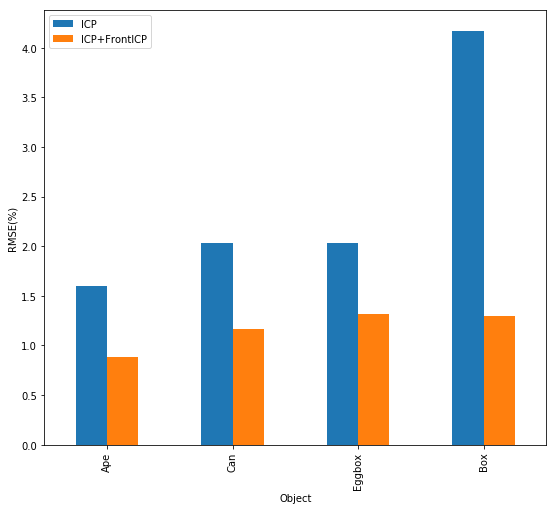

In [69]:
import pandas as pd
    
data=[["Ape",RMSE_ape_1,RMSE_ape_2],
      ["Can",RMSE_can_1,RMSE_can_2],
      ["Eggbox",RMSE_eggbox_1,RMSE_eggbox_2],
      ["Box",RMSE_box_1,RMSE_box_2]]

df=pd.DataFrame(data,columns=["Object","ICP","ICP+FrontICP"])
ax = df.plot(x="Object",y=["ICP","ICP+FrontICP"], kind="bar",figsize=(9,8))
ax.set_ylabel("RMSE(%)")
plt.show()

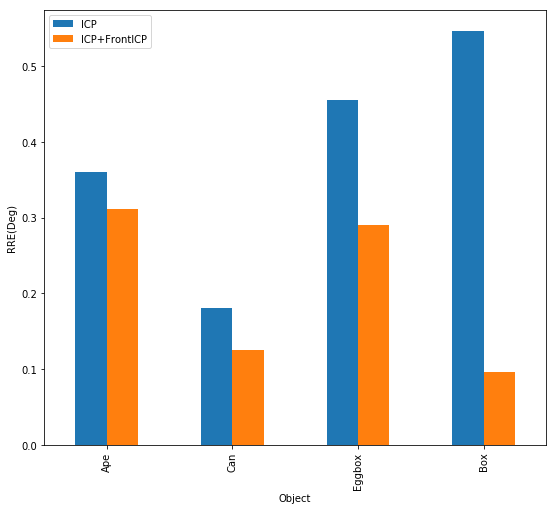

In [70]:
data=[["Ape",RRE_ape_1,RRE_ape_2],
      ["Can",RRE_can_1,RRE_can_2],
      ["Eggbox",RRE_eggbox_1,RRE_eggbox_2],
      ["Box",RRE_box_1,RRE_box_2]]

df=pd.DataFrame(data,columns=["Object","ICP","ICP+FrontICP"])
ax = df.plot(x="Object",y=["ICP","ICP+FrontICP"], kind="bar",figsize=(9,8))
ax.set_ylabel("RRE(Deg)")
plt.show()

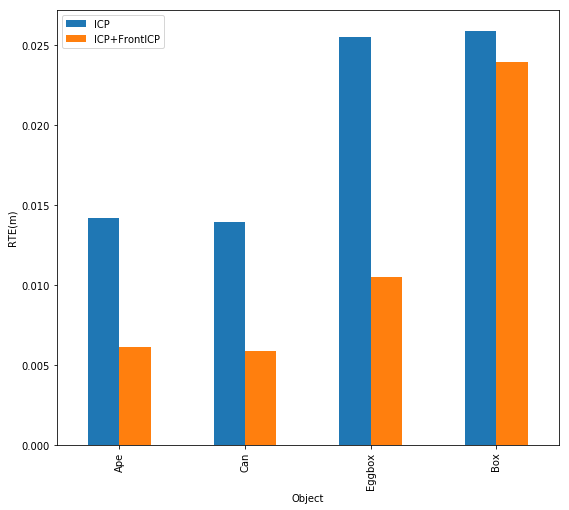

In [71]:
data=[["Ape",RTE_ape_1,RTE_ape_2],
      ["Can",RTE_can_1,RTE_can_2],
      ["Eggbox",RTE_eggbox_1,RTE_eggbox_2],
      ["Box",RTE_box_1,RTE_box_2]]

df=pd.DataFrame(data,columns=["Object","ICP","ICP+FrontICP"])
ax = df.plot(x="Object",y=["ICP","ICP+FrontICP"], kind="bar",figsize=(9,8))
ax.set_ylabel("RTE(m)")
plt.show()

## Get G.T pose

In [3]:
from cv2 import aruco
from pkg.detector.aruco.detector import *

# cameraMatrix = np.array([[899.05322266, 0.,         654.88366699],
#                          [0.,        899.21044922,  352.92956543],
#                          [0.,        0.,         1.]])

# distCoeffs = np.array([ 0.15870179, -0.46903715, -0.0014261 ,  0.00066797,  0.41631824])

cameraMatrix = np.array([[599.36883545, 0.,             329.92245483],
                         [0.,           599.47363281,   235.28637695],
                         [0.,           0.,             1.]])

# cameraMatrix = np.array([[607.32775879,   0.,         330.39055408],
#                          [  0.,         607.54418945, 234.63833445],
#                          [  0.,           0.,           1.        ]])

distCoeffs = np.array([0.15870179, -0.46903715, -0.0014261 ,  0.00066797,  0.41631824])

def get_aruco_map_test(test_name, mk_idx, mk_size, point=[0,0,0], direction=(0,0,0)):
    dictionary = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    #     params = aruco.DetectorParameters_create()

    aruco_map = ArucoMap(dictionary=dictionary, _dict={
        test_name: MarkerSet(test_name,
                         dlevel=DetectionLevel.ENVIRONMENT, gtype=GEOTYPE.BOX, dims=(0.1, 0.1,0.1), color=(0.8,0.0,0.0,1),
                         _list=[
                             ObjectMarker(test_name, mk_idx, mk_size, point, direction)
                         ])
    })
    return aruco_map

In [4]:
from pkg.detector.aruco.marker_config import get_aruco_map
import matplotlib.pyplot as plt
import yaml
data = {}
img_list = os.listdir(os.path.join(os.getcwd(), "capture_dataset/color/"))
img_list = sorted(img_list)
model = o3d.io.read_triangle_mesh(os.path.join(os.getcwd(), "model_CAD/cuboid.STL"))
model.vertices = o3d.utility.Vector3dVector(
            np.asarray(model.vertices) * np.array([1e-3, 1e-3, 1e-3]))
pcd = model.sample_points_uniformly(number_of_points=900000)
points = np.asarray(pcd.points)

# mask_gt = np.zeros((720, 1280)).astype(np.uint8)
# for i in range(len(img_list)):
for i in range(1):
    color_image = cv2.imread(os.path.join(os.getcwd(), "capture_dataset/color/", img_list[i]), flags=cv2.IMREAD_UNCHANGED)
    aruco_map_total = get_aruco_map()
    obj_dict, corner_dict = aruco_map_total.get_object_pose_dict(color_image, cameraMatrix, distCoeffs)
    img_out = aruco_map_total.draw_objects(color_image, obj_dict, corner_dict, cameraMatrix, distCoeffs)
#     plt.imshow(img_out[:,:,[2,1,0]])
    Tc_gt = obj_dict['dl_test']
    R = Tc_gt[:3,:3]
    t = Tc_gt[:3,3] * 1000.

    # projection the model to generate mask label
    mask_gt = np.zeros((480, 640)).astype(np.uint8)
    points_cam = np.matmul(R, points.T).T + t
    pixel_coord = np.matmul(cameraMatrix, points_cam.T).T
    for j in range(pixel_coord.shape[0]):
        u = pixel_coord[j,0]/pixel_coord[j,2]
        v = pixel_coord[j,1]/pixel_coord[j,2]
        if u>=0 and v >=0 and u<640 and v < 480:
            mask_gt[int(v),int(u)] =  255
#     plt.imshow(mask_gt)
    cv2.imwrite(os.path.join(os.getcwd(),"capture_dataset/mask/{0:04}.png".format(i)), mask_gt)
    
    # bouding box from masking
    v_min = np.min(np.where(mask_gt==255)[0])
    v_max = np.max(np.where(mask_gt==255)[0])
    u_min = np.min(np.where(mask_gt==255)[1])
    u_max = np.max(np.where(mask_gt==255)[1])
    bbox_data = [int(u_min), int(u_max), int(v_min), int(v_max)]
    
    data[i] = [{'cam_R_m2c':[float(R[0,0]), float(R[0,1]), float(R[0,2]),
                             float(R[1,0]), float(R[1,1]), float(R[1,2]),
                             float(R[2,0]), float(R[2,1]), float(R[2,2])],
                'cam_t_m2c':[float(t[0]), float(t[1]), float(t[2])],
                'obj_bb':bbox_data,
                'obj_id':1}]
    print(i)

0


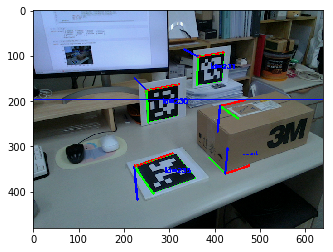

In [5]:
plt.imshow(img_out[:,:,[2,1,0]])

In [5]:
with open("gt.yml", "w") as f:
    yaml.dump(data, f)

In [3]:
img_list = os.listdir(os.path.join(os.getcwd(), "capture_dataset/color_bak/"))
img_list = sorted(img_list)
for i in range(len(img_list)):
    color_image = cv2.imread(os.path.join(os.getcwd(), "capture_dataset/color_bak/", img_list[i]), flags=cv2.IMREAD_UNCHANGED)
#     color_resize = cv2.resize(color_image, dsize=(640, 480), interpolation=cv2.INTER_AREA)
    cv2.imwrite(os.path.join(os.getcwd(), "capture_dataset/color/{0:04}.png".format(i)), color_image)
   
    depth_image = cv2.imread(os.path.join(os.getcwd(), "capture_dataset/depth_bak/", img_list[i]), flags=cv2.IMREAD_UNCHANGED)
#     depth_resize = cv2.resize(depth_image, dsize=(640, 480), interpolation=cv2.INTER_AREA)
    cv2.imwrite(os.path.join(os.getcwd(), "capture_dataset/depth/{0:04}.png".format(i)), depth_image)
    
#     mask_image = cv2.imread(os.path.join(os.getcwd(), "capture_dataset/mask/", img_list[i]), flags=cv2.IMREAD_UNCHANGED)
# #     mask_resize = cv2.resize(mask_image, dsize=(640, 480), interpolation=cv2.INTER_AREA)
#     cv2.imwrite(os.path.join(os.getcwd(), "capture_dataset/mask/{0:04}.png".format(i)), mask_image)


In [10]:
# cameraMatrix = np.array([[899.05322266, 0.,         654.88366699],
#                          [0.,        899.21044922,  352.92956543],
#                          [0.,        0.,         1.]])
d_scale = 0.000250000011874
K = cameraMatrix

import yaml
info_data = {}
img_list = os.listdir(os.path.join(os.getcwd(), "capture_dataset/color/"))
img_list = sorted(img_list)
for i in range(len(img_list)):
    info_data[i] = {'cam_K':[float(K[0,0]), float(K[0,1]), float(K[0,2]),
                             float(K[1,0]), float(K[1,1]), float(K[1,2]),
                             float(K[2,0]), float(K[2,1]), float(K[2,2])],
                    'depth_scale':float(d_scale)}

In [11]:
with open("info.yml", "w") as f:
    yaml.dump(info_data, f)

In [12]:
with open("train.txt", "w") as f:
    for i in range(len(img_list)):
        f.write("{0:04}\n".format(i))

In [3]:
import cv2
intrins=[1280, 720, 909.95776367, 909.90283203, 638.38244629, 380.0085144]
depth_scale = 0.0002500000118743628

color_img = cv2.imread('../demo_202107/save_img/closet_7.jpg', flags=cv2.IMREAD_UNCHANGED)
depth_img = cv2.imread('../demo_202107/save_img/closet_7.png', flags=cv2.IMREAD_UNCHANGED)
color = o3d.geometry.Image(color_img)
depth = o3d.geometry.Image(depth_img)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth, depth_scale=1 / depth_scale,
                                                                depth_trunc=10.0,
                                                                convert_rgb_to_intensity=True)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,
                                                     o3d.camera.PinholeCameraIntrinsic(*intrins))

In [12]:
source = copy.deepcopy(pcd)
target = copy.deepcopy(pcd)
trans = SE3(np.identity(3), (0.15, 0.35, -0.05))
source.transform(trans)
source.paint_uniform_color((1,0,0))
target.paint_uniform_color((0,1,0))
o3d.visualization.draw_geometries([source, target])

In [13]:
print("Apply point-to-point ICP")
threshold = 0.15
trans_init = np.identity(4)
reg_p2p = o3d.registration.registration_icp(source, target, threshold, trans_init,
                                            o3d.registration.TransformationEstimationPointToPoint(),
                                            o3d.registration.ICPConvergenceCriteria())

Apply point-to-point ICP


In [14]:
source.transform(reg_p2p.transformation)
source.paint_uniform_color((1,0,0))
target.paint_uniform_color((0,1,0))
o3d.visualization.draw_geometries([source, target])

## Check ICP accuracy (own dataset)

In [4]:
intrins = [640, 480, 599.36883545, 599.47363281, 329.92245483, 235.28637695]
depth_scale = 0.000250000011874

In [6]:
import random
T_co = []
rmse_ICP_list = []
rmse_frontICP_list = []
RRE_ICP_list = []
RTE_ICP_list = []
RRE_frontICP_list = []
RTE_frontICP_list = []
img_list = os.listdir(os.path.join(os.getcwd(), "capture_dataset/color/"))
with open('./gt.yml'.format(i), "r") as f:
    gt = yaml.load(f)
# for j in range(len(img_list)):
for j in range(2):
    j = j+1
    color_path = os.path.join(os.getcwd(), 'capture_dataset/color/{0:04}.png'.format(j))
    depth_path = os.path.join(os.getcwd(), 'capture_dataset/depth/{0:04}.png'.format(j))
    mask_path = os.path.join(os.getcwd(), 'capture_dataset/mask/{0:04}.png'.format(j))

    color = cv2.imread(color_path, flags=cv2.IMREAD_UNCHANGED)
    depth = cv2.imread(depth_path, flags=cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path, flags=cv2.IMREAD_UNCHANGED)
    mask_u8 = np.zeros_like(mask).astype(np.uint8)
    mask_u8[np.where(mask)] = 255

    color_masked = cv2.bitwise_and(color, color, mask=mask_u8).astype(np.uint8)
    depth_masked = cv2.bitwise_and(depth, depth, mask=mask_u8).astype(np.uint16)
#         plt.imshow(color_masked[:,:,[2,1,0]])
    cdp_masked = ColorDepthMap(color_masked, depth_masked, intrins, depth_scale)

    if cdp_masked.color is None:
        pass
    else:
        icp_obj = MultiICP(model=os.path.join(
                        os.getcwd(),'cuboid.ply'),
                        Toff=SE3(np.identity(3),(0,0,0)), scale=1e-3)
        icp_obj.add_image(cdp_masked, Tc=None)

    #     Tguess = SE3(Rot_axis(1, 2*np.pi/3), (-0.15,0,0.7))
#             Tguess = icp_obj.get_initial_by_center(Rot_axis(1, 2*np.pi/3), offset=(-0.0,0.2,0.1))
#         Tguess = icp_obj.get_initial_by_center(np.identity(3), offset=(0.0,0.0,0.0))
        r = gt[j][0]['cam_R_m2c']
        R_gt = np.array([[r[0], r[1], r[2]],
                      [r[3], r[4], r[5]],
                      [r[6], r[7], r[8]]])
        T_gt = np.array(gt[j][0]['cam_t_m2c']) * 1e-3
        
        # random offset
        dim = np.linalg.norm(icp_obj.model.get_max_bound() - icp_obj.model.get_min_bound())
        t_delta = (random.uniform(-dim/3., dim/3.),
                   random.uniform(-dim/3., dim/3.),
                   random.uniform(-dim/3., dim/3.))
        T_est = T_gt + t_delta
        Tguess = SE3(R_gt, T_est)
        T_ICP, rmse_ICP = icp_obj.compute_ICP(To=Tguess, thres=dim/2., visualize=True)
        T_frontICP, rmse_frontICP = icp_obj.compute_front_ICP(To=Tguess, thres=dim/2., visualize=True)
        
        RRE_ICP = np.arccos((np.trace(np.matmul(T_ICP[:3,:3].T, R_gt))-1)/2)
        RTE_ICP = np.linalg.norm(T_ICP[:3,3] - T_gt)
        
        RRE_frontICP = np.arccos((np.trace(np.matmul(T_frontICP[:3,:3].T, R_gt))-1)/2)
        RTE_frontICP = np.linalg.norm(T_frontICP[:3,3] - T_gt)
        print("+++++++++++++++++++++++++++++++++++")
        print("RRE_ICP(degree): {}".format(RRE_ICP))
        print("RTE_ICP(m): {}".format(RTE_ICP))
        print("RRE_frontICP(degree): {}".format(RRE_frontICP))
        print("RTE_frontICP(m): {}".format(RTE_frontICP))
        print("+++++++++++++++++++++++++++++++++++")
        T_co.append(T_frontICP)
        rmse_ICP_list.append(rmse_ICP)
        rmse_frontICP_list.append(rmse_frontICP)
        RRE_ICP_list.append(RRE_ICP)
        RTE_ICP_list.append(RTE_ICP)
        
        RRE_frontICP_list.append(RRE_frontICP)
        RTE_frontICP_list.append(RTE_frontICP)

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=4.074695e-02, and correspondence_set size of 852
Access transformation to get result.
Transformation is:
[[ 0.92764067 -0.34486562  0.14335467  0.10691704]
 [-0.23277046 -0.83404161 -0.50019247  0.18749155]
 [ 0.29206293  0.43063008 -0.85396545  0.91003469]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=6.653879e-03, and correspondence_set size of 1398
Access transformation to get result.
Transformation is:
[[ 0.89489457 -0.4462707   0.00249687  0.13897936]
 [-0.21854023 -0.44309724 -0.869428    0.17718831]
 [ 0.38910658  0.77750066 -0.49405341  0.87963028]
 [ 0.          0.          0.          1.        ]]
+++++++++++++++++++++++++++++++++++
RRE_ICP(degree): 0.564616162677
RTE_ICP(m): 0.0345749527343
RRE_frontICP(degree): 0.0209110100177
RTE_frontICP(m): 0.0273215765183
++++++++++++++++++

KeyboardInterrupt: 

In [62]:
RRE_ICP_mean = np.mean(np.asarray(RRE_ICP_list))
RTE_ICP_mean = np.mean(np.asarray(RTE_ICP_list))

RRE_frontICP_mean = np.mean(np.asarray(RRE_frontICP_list))
RTE_frontICP_mean = np.mean(np.asarray(RTE_frontICP_list))

RMSE_ICP_mean = np.mean(np.asarray(rmse_ICP_list))
RMSE_frontICP_mean = np.mean(np.asarray(rmse_frontICP_list))

In [63]:
print("RMSE(ICP): {}".format(RMSE_ICP_mean))
print("RMSE(frontICP): {}".format(RMSE_frontICP_mean))

RMSE(ICP): 0.0417271413198
RMSE(frontICP): 0.0129519446406


In [64]:
print("RRE_mean(ICP): {}".format(RRE_ICP_mean))
print("RRE_mean(frontICP): {}".format(RRE_frontICP_mean))

RRE_mean(ICP): 0.547152919959
RRE_mean(frontICP): 0.0964043926245


In [65]:
print("RTE_mean(ICP): {}".format(RTE_ICP_mean))
print("RTE_mean(frontICP): {}".format(RTE_frontICP_mean))

RTE_mean(ICP): 0.0258886570838
RTE_mean(frontICP): 0.0239395720432


In [66]:
print("Object Dimension[m]:")
print(icp_obj.model.get_max_bound() - icp_obj.model.get_min_bound())
np.linalg.norm(icp_obj.model.get_max_bound() - icp_obj.model.get_min_bound())

Object Dimension[m]:
[0.37  0.19  0.145]


0.44048268978474053

In [67]:
RMSE_box_1 = RMSE_ICP_mean * 100.
RRE_box_1 = RRE_ICP_mean
RTE_box_1 = RTE_ICP_mean

RMSE_box_2 = RMSE_frontICP_mean * 100.
RRE_box_2 = RRE_frontICP_mean
RTE_box_2 = RTE_frontICP_mean